---
---
# <center>Fachprojekt Data Mining and Data Analysis</center>


## <center>Sword Wielding Peacocks</center>   

__<center>Janis Büse</center>__  
<center>Technische Universität Dortmund</center>
<center>Janis.Buese@tu-dortmund.de</center>

__<center>Konstantin Haupt</center>__  
<center>Technische Universität Dortmund</center>
<center>Konstantin.Haupt@tu-dortmund.de</center>

__<center>Felix Schulte</center>__  
<center>Technische Universität Dortmund</center>
<center>Felix2.Schulte@tu-dortmund.de</center>

---
---

# Table of Contents

* [0 Introduction](#chapter0)
* [1 Extract High-Level Features](#chapter1)
    * [1.1 Number of non-zero pixels, average over non-zero pixels and 10 highest energy pixels](#section_1_1)
    * [1.2 Rotation of highest energy segment](#section_1_2)
    * [1.3 Blob detection](#section_1_3)
    * [1.4 Shape, location and Size of possible Gamma-Ray](#section_1_4)
    * [1.5 Center of impact](#section_1_5)
    * [1.6 Feature extraction](#section_1_6)
* [2 Choose a Validation Protocol](#chapter2)
* [3 Decision tree classification](#chapter3)
* [4 Linear model](#chapter4)
    * [4.1 Ridge Classifier](#section_4_1)
    * [4.2 Logistic Regression](#section_4_2)
    * [4.3 Stochastic Gradient Descent Classifier (SDG)](#section_4_3)
* [5 Suppport Vector Machines (SVM)](#chapter5)
    * [5.1 'Classic' Support Vector Classifier (SVC)](#section_5_1)
    * [5.2 LinearSVC](#section_5_2)
* [6 Random Forest Classification](#chapter6)
    * [6.1 'Classic' Random Forest](#section_6_1)
    * [6.2 XGBoost](#section_6_2)
* [7 Neural network-multilayer perceptron](#chapter7)
* [8 Neural network-Tensorflow](#chapter8)
* [9 Ensemble learning / Custom classifier combination](#chapter9)
    * [9.1 Prepare Classifiers](#section_9_1)
    * [9.2 Build combined Classifier](#section_9_2)
    * [9.3 Ensemble learning with Stacking Classifier](#section_9_3)
* [10 Final Submission](#chapter10)

---
# 0 Introduction <a class="anchor" id="chapter0"></a>

In this project, we will discuss different approaches to tell apart gamma-rays from other particles of the universe, which is known as 'Gamma-Hydron Separation'. In order to do so, we will extract different features from a given set of particle observations, which could potentially characterize gamma-rays. Afterwards, we use different classifier-algorithms in order to distinguish those gamma-rays from non-relevant observations.  

The following code contains basic library imports and loads the sample data, aswell as the test data and their extracted feature sets. In addition, 10 random data samples are shown; a data sample is provided as a two dimensional array, so each value can be interpreted as a pixel. Especially as it comes to the feature extraction, we think it is way easier to think of the samples as pictures with pixels rather than pure arrays with individual array values.  

As it comes to the plots for different hyperparameter-configurations of the classifiers, we already precomputed inital results by executing the given code in advance. If the values are supposed to be computated again, the given array allocations have to be deleted (or marked as a comment).

Loading Data
Data Loaded
Let&#39;s shuffle the data


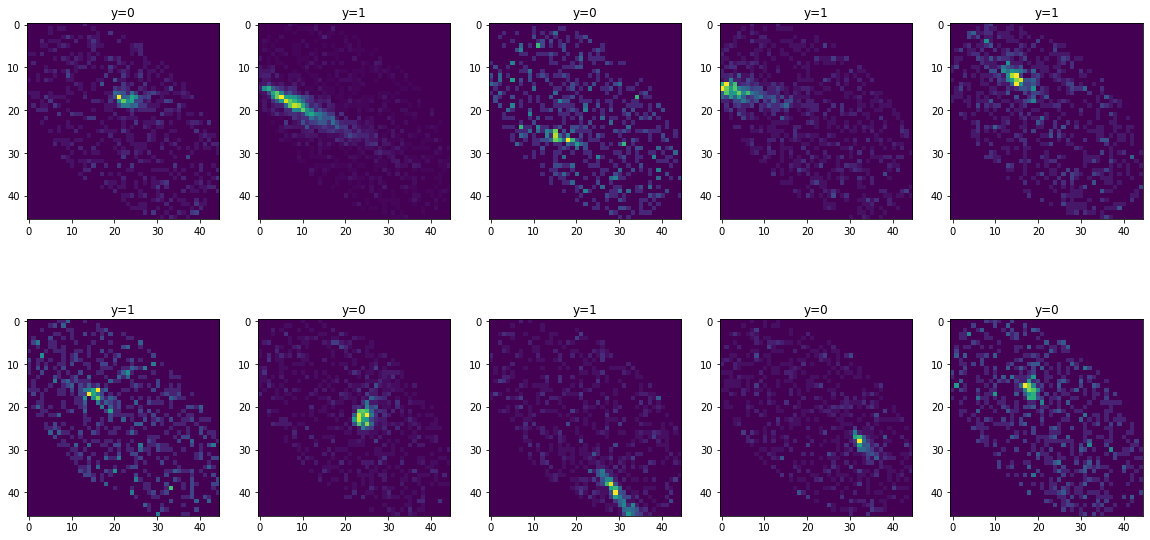

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import ndimage
from scipy.ndimage.interpolation import rotate
import sklearn
from matplotlib.pyplot import imshow, figure, subplot

import cv2
from matplotlib import pyplot as plt
from math import pi
from math import isnan
import matplotlib.pyplot as plt

import time
from PIL import Image

print("Loading Data")
trainingdata = np.load("trainingdata.npy")
trainingdata_labels   = np.load("trainingdata_labels.npy")
trainingdata_features = np.load("trainingdata_features.npy")
testdata_features = np.load("testdata_features.npy")
print("Data Loaded")

print("Let's shuffle the data")
shuffle = np.random.choice(len(trainingdata), len(trainingdata), replace=False)
trainingdata          = trainingdata[shuffle]
trainingdata_labels   = trainingdata_labels[shuffle]
trainingdata_features = trainingdata_features[shuffle]

figure(figsize=(20,10))
for i in range(10):
    subplot(2, 5, i + 1).title.set_text('y={}'.format(trainingdata_labels[i]))
    imshow(trainingdata[i] / trainingdata[i].max())

---
# 1 Extract High-Level Features <a class="anchor" id="chapter1"></a>


In this section the high-level features of the captured images are extracted.  
The following (random) data sample is used to show the functioning of each feature.

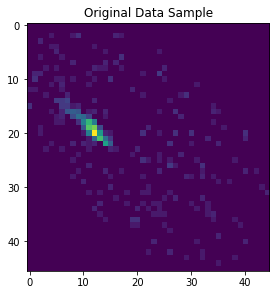

## 1.1 Number of non-zero pixels, average over non-zero pixels and 10 highest energy pixels <a class="anchor" id="#section_1_1"></a>

The captured images are presented as Numpy-Arrays containing the energy values for each pixel. With a variation of Numpys nonzero-method it is possible to extract only the non-zero pixels. We can extract a few features from those non zero-pixels:

1. Number of non-zero pixels
2. Average of non-zero pixels
3. Average of highest energy pixels (Arithmetic)



In [45]:
def extractNonZeroPixels(image):
    img = np.array(image, copy=True)

    # Extract non zero-pixels
    nonZeroPixels = img[img!=0]
    
    # Number of non-zero pixels
    numNonZeroPixels = len(nonZeroPixels)

    # Average of non-zero pixels (arithmetic mean)
    averageNonZeroPixels = nonZeroPixels.mean()
    if(isnan(averageNonZeroPixels)): averageNonZeroPixels=0

    # Extract 10 highest energy pixels (runs in linear time in the worst case)
    highPixelsInd = np.argpartition(nonZeroPixels, -10)[-10:]
    highestEnergyPixels = nonZeroPixels[highPixelsInd]

    # Average of highest energy pixels
    averageHighestEnergyPixels = highestEnergyPixels.mean()
    if(isnan(averageHighestEnergyPixels)): averageHighestEnergyPixels=0

    if(DEBUG):
        print("Number of non-zero pixels:  ", numNonZeroPixels)
        print("Average of non-zero pixels: ", averageNonZeroPixels)
        print("10 highest energy pixels:   ", highestEnergyPixels)
        print("Average high energy pixels: ", averageHighestEnergyPixels)

    return [numNonZeroPixels, averageNonZeroPixels, averageHighestEnergyPixels]

Number of non-zero pixels:   216
Average of non-zero pixels:  3.662037037037037
10 highest energy pixels:    [13. 13. 13. 16. 20. 22. 17. 24. 30. 21.]
Average high energy pixels:  18.9


##  1.2 Rotation of highest energy segment <a class="anchor" id="#section_1_2"></a>

On closer inspection of the images a point of impact surrounded by a scatter of lower energy points can be seen. We can extract the rotation of the point of impact and the general rotation of the overall spread by using Principal Component Analysis.

The first step is a threshold extraction of the main point of impact - the point where the high energy pixels are gathered. A PCA on an int representation of the extracted mask (true values for the high energy pixels) can provide the angle of the main impact. A PCA on the slightly blurred image can provide the angle of the overall scatter.

As an example the subplots show the original image rotated so that the given feature (rotation of main point of impact or rotation of overall scatter) is vertical.

In [19]:
from sklearn.decomposition.pca import PCA
from scipy.ndimage.interpolation import rotate
from math import pi

import os
import sys
import argparse
import skimage.morphology as morph
import skimage.exposure as skie


def getAngle(img):
  img = np.array(np.where(img > 0)).T
  pca = PCA(n_components=2).fit(img)
  angle = np.arctan2(*pca.components_[0])
  return angle


def thresholdExtraction(img, lowThresh, highThresh):
  limg = np.arcsinh(img)
  limg = limg / limg.max()
  low = np.percentile(limg, lowThresh)
  high = np.percentile(limg, highThresh)
  opt_img = skie.exposure.rescale_intensity(limg, in_range=(low, high))

  lm = morph.local_maxima(opt_img)
  return lm

rotation of main point of impact: 34.24327640547579 (radian: 0.5976579199460413 )
rotation of whole scatter:  44.1101521836373 (radian: 0.7698673891602372 )


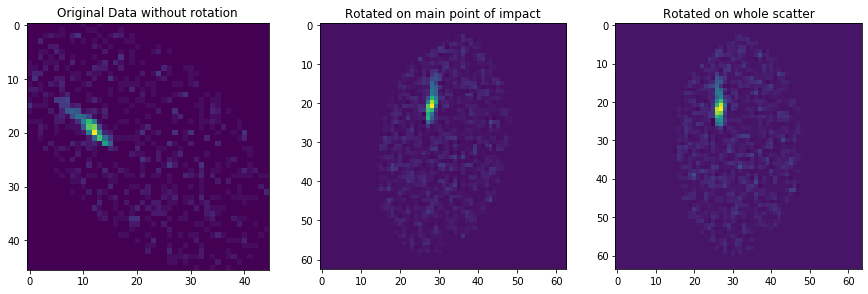

In [38]:
def extractRotation(img):
    img_gaussian = ndimage.gaussian_filter(img, 1)
    
    upperBound = 0
    foundMask = False

    # The threshold range may be to small for some images
    while (not foundMask) & (upperBound <= 5):
        # Extraction of the main point of impact
        boolMask = thresholdExtraction(img_gaussian, 95-(5*upperBound), 99)
        if(np.any(boolMask)):
            foundMask = True
        else:
            upperBound += 1

    # The mask from the threshold extraction can then be used for a PCA
    boolMaskAsInt = boolMask.astype(int)

    # PCA on boolMask converted to int
    anglePoint = getAngle(boolMaskAsInt)
    anglePointDegrees = anglePoint * (180/pi)
    rotated_img = rotate(img, anglePoint/pi*180-90)

    # PCA on slightly blurred original image
    angleScatter = getAngle(img)
    angleScatterDegrees = angleScatter * (180/pi)
    rotated_img_scatter = rotate(img, angleScatter/pi*180-90)

    if(DEBUG):
        print("rotation of main point of impact:",anglePointDegrees,"(radian:",anglePoint,")")
        print("rotation of whole scatter: ", angleScatterDegrees,"(radian:",angleScatter,")")

        plt.subplots(figsize=(15, 10))
        plt.subplot(231).title.set_text("Original Data without rotation")
        plt.imshow(img)
        plt.subplot(232).title.set_text("Rotated on main point of impact")
        plt.imshow(rotated_img)
        plt.subplot(233).title.set_text("Rotated on whole scatter")
        plt.imshow(rotated_img_scatter)
        plt.show()

    return [anglePointDegrees, angleScatterDegrees]

## 1.3 Blob detection <a class="anchor" id="#section_1_3"></a>

With blob detection we can find regions of an image that differ from the surrounding area. This difference could be a change in brightness or color. In the case of our 2D-Numpy-Arrays the areas that we are interested in are the impact areas - connected regions of pixels with a value >0. The `scikit-image`-collection provides three different implementations of blob detection: Laplacian of Gaussian (LoG), Difference of Gaussian (DoG) and Determinant of Hessian (DoH). LoG is the slowest and most accurate approach, DoG is (in most cases) the fastest approach. The kernel for LoG is created by the application of the Laplacian operator on a Gaussian function (also called Marr-Hildreth-Operator). It can then be used to detect changes in the image (edges) from which the blobs are gradually increased in size until reaching the end of the detectable region. The DoG implementation is a variation of LoG working on two blurred images. In theory the performance of LoG and DoG decreases with bigger blobs and DoH doesn't work well with small regions. Our images have a lot of small regions and except for the main point of impact the blobs should be fairly small. In a performance test (n=1000) we could not find a big performance difference between LoG and DoG so for our blob detection we use LoG because of the better accuracy.

In [21]:
from math import sqrt
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray

def blobs(image, minsigma, maxsigma, threshold, overlap):
  blobs_log = blob_log(image, min_sigma=minsigma,max_sigma=maxsigma, threshold=threshold, overlap=overlap)

  # Compute radii in the 3rd column.
  blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
  return blobs_log

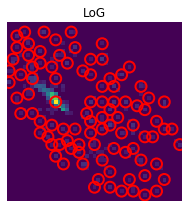

Number of detected blobs:  94


In [39]:
def extractBlobNumber(img):

    # Threshold extraction for better seperation of regions
    threshold_indices = img < 2
    img[threshold_indices] = 0

    # LoG based blob detection - parameters seem to work but could be changed for better results
    detectedBlobs = blobs(img, minsigma=1, maxsigma=16, threshold=0.05, overlap=0.6).tolist()

    # Plotting detected blobs on the image
    if(DEBUG):
        fig, axes = plt.subplots(1, 1, figsize=(9, 3), sharex=True, sharey=True)
        imshow(img)
        axes.set_title("LoG")
        for blob in detectedBlobs:
            y,x,r = blob
            c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
            axes.add_patch(c)
            axes.set_axis_off()
        plt.tight_layout()
        plt.show()

    # Feature that can be extracted from the detection
    numBlobs = len(detectedBlobs)

    if(DEBUG):
        print("Number of detected blobs: ", numBlobs)

    return numBlobs

## 1.4 Shape, location and Size of possible Gamma-Ray <a class="anchor" id="section_1_4"></a>

Although it seems like the overall shape and size is somehow unique in every observation, they may be related to their source and therefore can provide important features for recognizing Gamma-Rays. In order to extract those features, we firstly blur the image to filter out noise.

Afterwards, we need to define proper boundaries for the contour recognition. Initially, we wanted to use the already extracted information about the beam like the average of the non-zero energy pixels, as it would adjust the searched range dynamically to the characteristics of each specific image. But as it turns out, this strategy either filters to little and we get to many contours, or it filters to much and we loose a certain percentage of the high-energy area. Thus, we tried different fixed boundaries and figured, that '3' as a lower boundary is a good way to go. Regarding the upper boundary, we just chose a random high value, as we do not want to limit the bright areas in any way.

Finally, as we can assume that the largest contour represents the area of interest, we filter out the contour with the biggest area. As a additional feature, we compute the "shape" of the contour by computing the range on the x-axis and y-axis. This also tells us about the location of the contour in the image.

All found Contours:

23.0
--------------------------------
Coordinates of High-Enery-Beam:
 [[[ 7 15]]

 [[ 7 16]]

 [[ 8 17]]

 [[ 9 18]]

 [[10 19]]

 [[10 20]]

 [[11 21]]

 [[12 22]]

 [[13 22]]

 [[14 22]]

 [[15 22]]

 [[15 21]]

 [[14 20]]

 [[14 19]]

 [[13 18]]

 [[12 17]]

 [[11 17]]

 [[10 16]]

 [[ 9 16]]

 [[ 8 16]]]
--------------------------------
Size of High-Energy-Beam:
 23.0
--------------------------------
Maximum Ranges:
 X-Range:
 7  -  15 
 Y-Range:
 15  -  22 
 --------------------------------


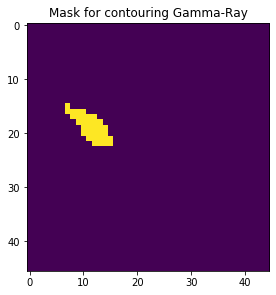

In [43]:
def extractShapeLocation(Img):
    shapeImg = np.array(Img, copy=True)

    # Filter out noise using a Gauss-Filter
    shapeImgGaussian = cv2.GaussianBlur(shapeImg, (5, 5), 0)

    # Decrease lower Boundary with each iteration. Otherwise, some samples wouldn't get a proper mask to detect the contours
    foundContour = False
    lowerBound = 3
    while (not foundContour) & (lowerBound >= 0):

        # Define boundaries for contour-recognition-mask
        lower_boundary = np.array(lowerBound)
        upper_boundary = np.array([100])

        # Use boundaries to compute a mask for contour-recognition
        mask = cv2.inRange(shapeImgGaussian, lower_boundary, upper_boundary)

        if(DEBUG):
            figure(figsize=(20,5))
            plt.subplot(141)
            plt.imshow(mask)
            plt.title('Mask for contouring Gamma-Ray')

        # Use build-in function and computed mask to scan image for possible contours
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if(DEBUG):
            print("All found Contours:\n")
            for contour in contours:
                print(cv2.contourArea(contour))
            print("--------------------------------")
        
        if len(contours) > 0:
            foundContour = True
        else:
            lowerBound -= 1


    if not foundContour:
        raise ValueError("-------------------------------\n" +
                            "ERROR: Coudn't find any Contours in Sample\n" +
                         "-------------------------------\n")


    # Assuming that the biggest contour represents the high-enery-beam
    contourAreas = list()
    for contour in contours:
        contourAreas.append(cv2.contourArea(contour))

    contourOfInterest = contours[contourAreas.index(max(contourAreas))]
    if(DEBUG):
        print("Coordinates of High-Enery-Beam:\n", contourOfInterest)
        print("--------------------------------")

    # Area of the high-energy-beam
    areaOfInterest = cv2.contourArea(contourOfInterest)
    if(DEBUG):
        print("Size of High-Energy-Beam:\n", areaOfInterest)
        print("--------------------------------")

    # Calculating Range of high-energy-beam
    areaMinX = 1000
    areaMinY = 1000
    areaMaxX = 0
    areaMaxY = 0

    for i in range(len(contourOfInterest)):
        for j in range(len(contourOfInterest[i])):
            if contourOfInterest[i][j][0] < areaMinX:
                areaMinX = contourOfInterest[i][j][0]
            
            if contourOfInterest[i][j][1] < areaMinY:
                areaMinY = contourOfInterest[i][j][1]

            if contourOfInterest[i][j][0] > areaMaxX:
                areaMaxX = contourOfInterest[i][j][0]

            if contourOfInterest[i][j][1] > areaMaxY:
                areaMaxY = contourOfInterest[i][j][1]

    if(DEBUG):
        print("Maximum Ranges:\n", "X-Range:\n", areaMinX, " - ", areaMaxX, "\n", "Y-Range:\n", areaMinY, " - ", areaMaxY, "\n", "--------------------------------")

    return [areaOfInterest, areaMinX, areaMaxX, areaMinY, areaMaxY, (areaMaxX - areaMinX), (areaMaxY - areaMinY)]

## 1.5 Center of impact <a class="anchor" id="section_1_5"></a>

In this step a simple euclidean distance transform is performed on the image. For each pixel the euclidean distance to the nearest boundary pixel (a pixel with value 0) is calculated. A feature that can be extracted from the output distance matrix is the index of the pixel with the highest distance. This pixel is most likely the pixel right in the center of the main impact. We can also extract the actual distance value of that pixel.

In [44]:
def extractHighestDistance(img):
    transf = ndimage.distance_transform_edt(img)
    
    # Get the index of the highest value in the calculated distance matrix
    highestDistanceIndex = np.unravel_index(np.argmax(img, axis=None), img.shape)
    highestDistance = transf[highestDistanceIndex]

    indexX = highestDistanceIndex[0]
    indexY = highestDistanceIndex[1]

    if(DEBUG):
        print("Index X: ", highestDistanceIndex[0])
        print("Index Y: ", highestDistanceIndex[1])
        print("Value: ", highestDistance)
        
    return [indexX, indexY, highestDistance]

Index X:  20
Index Y:  12
Value:  2.23606797749979


## 1.6 Feature extraction <a class="anchor" id="section_1_6"></a>
For our feature extraction we created a simple loop that works its way through each image and applies our extraction functions. In this process we found out that e.g. the image at index 175575 of the training dataset is an image containing nearly no information. Thus, we added Exception-Handling at critical functions. The results of the extraction are combined into an array of size 16 (so 16 features are extracted). We extracted the following features:
- Number of non-zero pixels
- Average of non-zero pixels
- Average of the 10 highest energy pixels
- Rotation of main point of impact
- Rotation of (general) scatter
- Number of detected blobs (from LoG Blob detection)
- size and orientation of high-energy beam: (7 features)
  - areaOfInterest 
  - areaMinX, areaMaxX, areaMinY, areaMaxY 
  - (areaMaxX - areaMinX)
  - (areaMaxY - areaMinY)
- Center of impact: (3 features)
  - Index X & Y of highest distance pixel
  - highest distance value



In [47]:
#Extract features for training dataset
DEBUG = False             # Execute everything with Debug-Comments

testdata = np.load("testdata.npy")

extracted_Features = []
t0 = time.clock()
counter = 0
for img in testdata:
    currentImgFeatures = []
    currentImgFeatures.extend(extractNonZeroPixels(img))

    try:
        currentImgFeatures.extend(extractRotation(img))
    except ValueError as err:
        print("extractRotation: error on image", counter)
        currentImgFeatures.extend([0,0])

    currentImgFeatures.append(extractBlobNumber(img))

    try:
        currentImgFeatures.extend(extractShapeLocation(img))
    except ValueError as err:
        print("extractShapeLocation: error on image", counter)
        currentImgFeatures.extend([0,0,0,0,0,0,0])   

    currentImgFeatures.extend(extractHighestDistance(img))
    
    currentImgNp = np.asarray(currentImgFeatures)
    extracted_Features.append(currentImgNp)
    counter += 1

print("Time for extraction: ", time.clock() - t0)
nparray = np.asarray(extracted_Features)
if(DEBUG):
    print("Lenght of Feature-Array: ", len(nparray),"\n",
            "Shape of Feature-Array: ", nparray.shape,"\n",
            "Content of Feature-Array: ", nparray,"\n")
np.save('testdata_features.npy', nparray)

---
# 2 Choose a Validation Protocol <a class="anchor" id="chapter2"></a>

### Crossvalidation 
-> technique for evaluating the performance (or accuracy) of a (machine learning) model.

After training a model you obviously can not assume that it will perform well on data it has never seen. The basic idea of crossvalidation is to not use the whole sample data on training, but to keep an amount of it for validation. There are many different variations of crossvalidation (holdout, k-fold, stratified k-fold, leave-p-out) but one of the most popular ones is k-folds crossvalidation.

The problem with a simple split of the data into training data and validation data is that you lose a big amount of data for training. Another problem is that the validation data might have features that are not available in the training data and therefore will be missed by the model. So a simple split into 80-20 is only acceptable for huge amounts of sample data. A solution (kind of) for this problem is the k-folds crossvalidation. This technique allows every single dataset of the sample data to appear in training and validation data. This can be done by splitting the sample data into **k** folds (pieces) of same length **(5≤k≤10)**. The model is then trained with **k−1** of the folds. The remaining fold is used for the validation. This step is repeated until every fold has been used for validation. The average of the scores (accuracy) of each repetition is the final score of the k-folds crossvalidation.

*(source: Janis glossary entry)*

Crossvalidation will take longer computing times than for example a simple holdout split because of the repetitions. But the result of the crossvalidation is much more statistically significant because the whole dataset can be used for validation. Therefore we decided to uscrossvalidation as a validation protocol for our models.

---
# 3 Decision tree classification <a class="anchor" id="chapter3"></a>

Decision tree learning is one of the most basic and 'easiest' classification methods. The name already describes the main tool of the method: a decision tree. A decision tree consists of nodes and splittings. The start of the tree is the root node which represents the entire sample data (no decision on splitting the data has been made yet). Each node (except for a leaf node) has two or more branches/splittings where the sample is divided into two or more sub-samples (split). Based on the values of the feature data, a data sample will be forwarded to one of the two (or more) connected nodes. The connected nodes can be decision nodes or leaf nodes. The decision nodes will continue to split the sample data. Once a sample reaches a leaf node, the classification is complete and the decision tree has "decided" on its class. The decisions the tree has made along the way are visible which makes the algorithm a white-box machine learning algorithm because it shares its internal decision-making logic. 

Decision trees can handle high-dimensional data which could be benefitial for us because our data consists of images of the size 46x45 pixels which makes the data 2070-dimensional. Also decision trees can capture non-linear patterns. A problem we could run into is that they are sensitive to noisy data and can overfit.

We did a little parameter tuning on the skikit-Decision-Trees with the help of GridSearchCV. GridSearchCV allows to define multiple values for one parameter end tests the performance of each combination of parameter-values. We found out that the best accurancy could be achieved by using the following configuration: 
> `{'criterion': 'entropy', 'max_depth': 15, 'max_features': 16, 'min_samples_split': 110, 'splitter': 'best'}`

The accuracy with simple-split is about 82%. A more precise examination with kFold-crossvalidation led to an accuracy of 0.77 (+/- 0.11).

Sources:  
- [An introduction to Decision Tree Classifier](https://towardsdatascience.com/decision-tree-classification-de64fc4d5aac)
- [Decision Tree Classification in Python](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)

In [5]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier         # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split    # Import train_test_split function
from sklearn.model_selection import cross_val_score     # Import cross_val_score function
from sklearn import metrics                             # Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import GridSearchCV, KFold # Import Utilities
from skopt import BayesSearchCV                         # Import BayesSearchCB (more optimised than GridSearchCV)

#split dataset in features and target variable / variables not used here but could be useful in the future
feature_cols = ["numNonZeroPixels", "avgNonZeroPixels", "averageTenHighestPixels", "rotationMainImpact","rotationScatter","numDetectedBlobs","areaOfInterest",
                "areaMinX","areaMaxX","areaMinY","areaMaxY","areaWidth","areaHeight","posXHighestDistance","posYHighestDistance","valueHighestDistance"]

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

# ----------- PARAMETER TEST -----------
# attempt to find best parameters for the decision tree
parameters = {  "max_depth":[x for x in range(6,30)],
                "criterion":["gini","entropy"],
                "splitter":["best","random"],
                "max_features":["auto","sqrt","log2",2,8,12,14,16],
                "min_samples_split":[x for x in range(60,110)]}

dtc = GridSearchCV(DecisionTreeClassifier(), parameters)
dtc.fit(X=X, y=y)
tree_model = dtc.best_estimator_
print (dtc.best_score_, dtc.best_params_) 
# ----------- PARAMETER TEST -----------


# Create Decision Tree classifier object
dtc = DecisionTreeClassifier(max_depth=14, criterion="entropy", max_features=16, min_samples_split=110, splitter="best")


# ------------ SIMPLE SPLIT ------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1) # 75% training

# Train Decision Tree Classifer
dtc = dtc.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = dtc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# ------------ SIMPLE SPLIT ------------


# ---------- CROSS VALIDATION ----------
kf = KFold(n_splits=5, shuffle=False, random_state=2652124)
scores = cross_val_score(dtc, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# ---------- CROSS VALIDATION ----------


# --------- PREDICT ON TESTDATA --------
dtc = dtc.fit(X,y)
y_pred = dtc.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

Accuracy: 0.82 (+/- 0.00)


{'score': 0.82292}

### In-depth look at some hyperparameters

For a better look at how the different hyperparameters affect the accuracy of the decision tree we generated some plots. We chose to set the other parameters to the values that had the best performance in the GridSearch (see above).

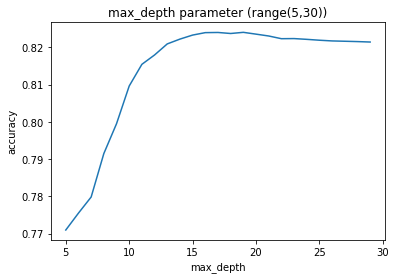

In [20]:
depths = range(5,30)
score_results = []

for depth in depths:
    dtc = DecisionTreeClassifier(max_depth=depth, criterion="entropy", max_features=16, min_samples_split=100, splitter="best")
    kf = KFold(n_splits=5)
    scores = cross_val_score(dtc, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
    score_results.append(scores.mean())

# pre-computed results
score_results= [0.7709750000000001, 0.77551, 0.7798250000000001, 0.791485, 0.79948, 0.8095950000000001, 0.81541, 0.81792, 0.820885, 0.822175, 0.823255, 0.82391, 0.823955, 0.8236800000000001, 0.82399, 0.8235050000000002, 0.82301, 0.8222850000000002, 0.822315, 0.82211, 0.821875, 0.8216849999999999, 0.8215999999999999, 0.82151, 0.8213899999999998]

plt.title("max_depth parameter (range(5,30))")
plt.plot(depths, score_results, label="scores")
plt.ylabel("accuracy")
plt.xlabel("max_depth")
plt.show()

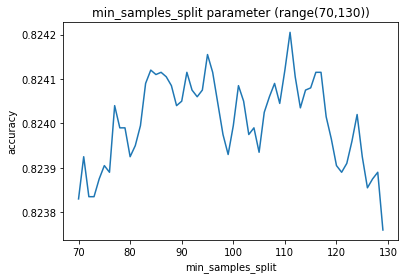

In [21]:
min_samples_splits = range(70,130)
score_results = []

for min_samples_split in min_samples_splits:
    dtc = DecisionTreeClassifier(max_depth=16, criterion="entropy", max_features=16, min_samples_split=min_samples_split, splitter="best")
    kf = KFold(n_splits=5)
    scores = cross_val_score(dtc, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
    score_results.append(scores.mean())

# pre-computed data
score_results = [0.8238300000000001, 0.823925, 0.8238349999999999, 0.8238350000000001, 0.8238749999999999, 0.8239049999999999, 0.8238899999999999, 0.8240399999999999, 0.8239899999999999, 0.8239899999999999, 0.823925, 0.82395, 0.823995, 0.82409, 0.82412, 0.8241099999999999, 0.8241149999999999, 0.824105, 0.824085, 0.8240400000000001, 0.82405, 0.8241150000000002, 0.824075, 0.82406, 0.8240749999999999, 0.824155, 0.8241149999999999, 0.8240449999999999, 0.8239750000000001, 0.82393, 0.823995, 0.824085, 0.82405, 0.8239750000000001, 0.82399, 0.823935, 0.824025, 0.82406, 0.82409, 0.8240449999999999, 0.8241200000000001, 0.8242050000000001, 0.824105, 0.8240350000000001, 0.824075, 0.82408, 0.8241150000000002, 0.8241149999999999, 0.8240149999999999, 0.8239650000000001, 0.8239050000000001, 0.8238899999999999, 0.82391, 0.8239599999999999, 0.82402, 0.823925, 0.823855, 0.8238749999999999, 0.8238900000000001, 0.82376]

plt.title("min_samples_split parameter (range(70,130))")
plt.plot(min_samples_splits, score_results, label="scores")
plt.ylabel("accuracy")
plt.xlabel("min_samples_split")
plt.show()

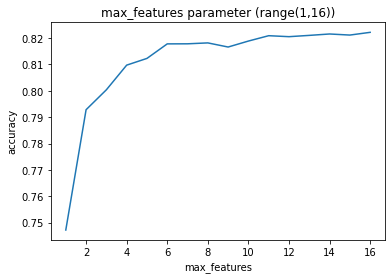

In [26]:
max_features_range = range(1,17)
score_results = []

for max_features in max_features_range:
    dtc = DecisionTreeClassifier(max_depth=14, criterion="entropy", max_features=max_features, min_samples_split=110, splitter="best")
    kf = KFold(n_splits=5)
    scores = cross_val_score(dtc, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
    score_results.append(scores.mean())

# pre-computed data
score_results = [0.747225, 0.79284, 0.800395, 0.80974, 0.812295, 0.8178049999999999, 0.8178300000000001, 0.8181750000000001, 0.8166100000000001, 0.818875, 0.820905, 0.8205350000000001, 0.821025, 0.821555, 0.8211450000000001, 0.82218]

plt.title("max_features parameter (range(1,17))")
plt.plot(max_features_range, score_results, label="scores")
plt.ylabel("accuracy")
plt.xlabel("max_features")
plt.show()

### Conclusion

Best result on training data: 82.11%  
Best result on test data: 82.32%

The Decision Tree was a nice introduction to get an idea for how a classifier works in general and how we are able to implement and use them in python. As there occured no problems in using the GridSearch like the runtime or conflicts for certain parameter configurations, we could focus on the correct implementation and try out different validation protocols for a start. Because the Decision Tree Classifer is the least complex classifier given in the tasks, we did not expect a high accuracy score. But as it turns out, the Classifier did seem to work out pretty well. We were pretty satisfied with the achieved results. For the following classifiers, we now had a 'starting point' of what to expect, and tried to improve the score of ~82% with the higher complex classifiers.

---
# 4 Linear model <a class="anchor" id="chapter4"></a>

Linear regression and logistic regression are two of the most widely used (linear) machine learning algorithms. The idea of them is to find a relationship between feature variables and a target variable. Features are often described as independent variables and the target variable as the dependent variable. When we plot our data (independent variables as x and target variable as y) we get a point cloud. Linear regression works by fitting a straight line through the point cloud so that the points can be classified by their position in relation to the line. A line is represented by _Y = mx + b_ where m is the slope and b is the offset (or Y intercept). Fitting the line to the point cloud can be done by plotting a line through the mean of the points and rotating it until the sum of the distance between each point and the line is maximized. In settings with more than 2-3 dimensions (i.e. >3 features) a hyperplane _Y = θ₀ + θ₁x₁ + θ₂x₂ + ... + θₙxₙ_ (where _θ_ represents the model parameter (rotation estimated using least-squares estimation) and _x_ the feature values) is computed. That is called multiple linear regression.   

But linear regression will predict a continuous value (for example body size based on weight) and we need a classification between 0 and 1. Thus, in our case we have to take a look at logistic regression. Logistic regression will fit a curve to the data. The position of the point in relation to the curve gives the probability of its affiliation to one of two classes. In logistic regression the line can not be fitted using the maximized distances (least squares or R^2). Instead the maximum likelihood method is used. The curve will be shifted multiple times and each time the likelihood (probability that the data point is classified to its corresponding class) is calculated. The best curve (maximum likelihood to predict the correct class) will be selected. To put it simple, logistic regression adapts linear regression to allow it to act as a classifier.

We will use two classifiers from the scikit library: LogisticRegression and RidgeClassifier. With the help of GridSearchCV we tried to find the best parameters for the models.  

For the RidgeClassifier: We achieved an accuracy of ~0.72 by using the configuration
 >`{'alpha': 1.0, 'fit_intercept': True, 'normalize': False, 'solver': 'sparse_cg'}`.
 
For the logistic regression: We achieved an accuracy of ~0.74 by using the configuration
>`{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}`.


Sources:  
Linear regression (simple and multiple):  
- [Linear Regression using Python](https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2)  
- [A beginner’s guide to Linear Regression in Python with Scikit-Learn](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)  
- [Simple and Multiple Linear Regression in Python](https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9)  

Polynomial regression:  
- [Polynomial Regression](https://towardsdatascience.com/polynomial-regression-bbe8b9d97491)

Linear vs Logistic regression:  
- [Linear Regression vs Logistic Regression](https://www.javatpoint.com/linear-regression-vs-logistic-regression-in-machine-learning)  
- [What is the difference between linear regression and logistic regression?](https://stackoverflow.com/questions/12146914/what-is-the-difference-between-linear-regression-and-logistic-regression)  

Logistic regression:  
- [The Basics: Logistic Regression and Regularization](https://towardsdatascience.com/the-basics-logistic-regression-and-regularization-828b0d2d206c)  
- [LOGISTIC REGRESSION CLASSIFIER](https://towardsdatascience.com/logistic-regression-classifier-8583e0c3cf9)  


In [4]:
from sklearn.linear_model import LogisticRegression      # Import main classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler         # Scaler 
from sklearn.pipeline import make_pipeline               # Pipeline für Scaler und SGDClassifier
from sklearn.model_selection import cross_val_score      # Import cross_val_score function
from sklearn.model_selection import GridSearchCV, KFold  # Import utilities

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

## 4.1 Ridge Classifier <a class="anchor" id="section_4_1"></a>

In [8]:
# ----------- PARAMETER TEST RIDGE CLASSIFIER -----------
attempt to find best parameters for the ridge classifier
parameters = {  "alpha":[0.5,1.0,1.5,2.0,3.0],
                "fit_intercept":[True,False],
                "normalize":[True,False],
                "solver":["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]}

ridge = GridSearchCV(RidgeClassifier(), parameters)
ridge.fit(X=X, y=y)
print (ridge.best_score_, ridge.best_params_) 
# ----------- PARAMETER TEST RIDGE CLASSIFIER -----------


# Create ridge classifier object
ridge = RidgeClassifier(fit_intercept=True,normalize=False,solver="sparse_cg")

# ---------- CROSS VALIDATION RIDGE CLASSIFIER ----------
kf = KFold(n_splits=5, shuffle=False, random_state=2652124)
scores = cross_val_score(ridge, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
print("Accuracy ridge: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# ---------- CROSS VALIDATION RIDGE CLASSIFIER ----------


# --------- PREDICT ON TESTDATA --------
ridge = ridge.fit(X,y)
y_pred = ridge.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

Accuracy ridge: 0.72 (+/- 0.00)


{'score': 0.72068}

## 4.2 Logistic Regression <a class="anchor" id="section_4_2"></a>

In [9]:
# ---------- PARAMETER TEST LOGISTIC REGRESSION ---------
# attempt to find best parameters for the logistic regression
parameters = {  "penalty":["l1", "l2", "elasticnet", "none"],
                "fit_intercept":[True,False],
                "solver":["newton-cg","lbfgs","liblinear", "sag", "saga"],
                "multi_class":["auto","ovr","multinomial"],
                "C":[0.001,0.01,0.1,1,10]}

logReg = GridSearchCV(LogisticRegression(), parameters)
logReg.fit(X=X, y=y)
print (logReg.best_score_, logReg.best_params_) 
# ---------- PARAMETER TEST LOGISTIC REGRESSION ---------


# Create logistic regression classifier object
logReg = LogisticRegression(C=1.0,fit_intercept=True,multi_class="auto",penalty="l1",solver="liblinear")

# ---------- CROSS VALIDATION LOGISTIC REGRESSION ----------
kf = KFold(n_splits=5, shuffle=False, random_state=2652124)
scores = cross_val_score(logReg, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
print("Accuracy logistic regression: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# ---------- CROSS VALIDATION LOGISTIC REGRESSION ---------


# --------- PREDICT ON TESTDATA --------
logReg = logReg.fit(X,y)
y_pred = logReg.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

Accuracy logistic regression: 0.74 (+/- 0.00)


{'score': 0.74048}

## 4.3 Stochastic Gradient Descent Classifier (SDG) <a class="anchor" id="section_4_3"></a> 

We also implemented the SGDClassifier as an optimization of LogisticRegression. In addition, the SGDClassifier also serves as an implementation of an SVM, which will be discussed detailly in the next chapter. With hyperparameter tuning we were able to achieve an accuracy of about ~0.74 for the configuration 
>`{[('alpha', 1e-06), ('early_stopping', True), ('eta0', 0.01), ('fit_intercept', True), ('learning_rate', 'adaptive'), ('loss', 'hinge'), ('max_iter', 1000), ('penalty', 'l1'), ('tol', 0.001), ('warm_start', True)]}`.

In [5]:
# this section will need the skopt (for BayesSearchCV) package:
#   skopt:  conda install -n fp -c conda-forge scikit-optimize

# -------------- PARAMETER TEST SGDClassifier -------------
# attempt to find best parameters for the SGDClassifier
parameters = {    "loss":["hinge","log","modified_huber","squared_hinge"],
                    "penalty":["l1", "l2", "elasticnet"], 
                    "alpha": 10.0 **-np.arange(1, 7),
                    "fit_intercept":[True,False],
                    "max_iter":[500,700,1000,1200,1500,2000],
                    "tol":[0.0001,0.001,0.01],
                    "n_jobs":-1, 
                    "learning_rate":["constant","optimal","invscaling","adaptive"],
                    "early_stopping":[True,False],
                    "warm_start":[True,False]
             }

sgdClf = make_pipeline(StandardScaler(), SGDClassifier())
logReg = GridSearchCV(sgdClf, parameters)
logReg.fit(X=X, y=y)
print (logReg.best_score_, logReg.best_params_) 
# -------------- PARAMETER TEST SGDClassifier -------------


# Create SGDClassifier object
sgdClf = make_pipeline(StandardScaler(), SGDClassifier(alpha=1e-06, early_stopping=True, eta0=0.01, fit_intercept=True, learning_rate="adaptive", max_iter=1000, l1_ratio=0.8, loss="hinge", penalty="l1", tol=0.001, warm_start=True))


# ------------ CROSS VALIDATION SGDClassifier -------------
kf = KFold(n_splits=5, shuffle=False, random_state=2652124)
scores = cross_val_score(sgdClf, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
print("Accuracy SGDClassifier: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# ------------ CROSS VALIDATION SGDClassifier -------------


# --------- PREDICT ON TESTDATA --------
sgdClf = sgdClf.fit(X,y)
y_pred = sgdClf.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

Accuracy SGDClassifier: 0.74 (+/- 0.00)


{'score': 0.74912}

### Conclusion

***Ridge Classifier:***  
Best result on training data: 72%  
Best result on test data: 72.06%

***Logistic Regression:***  
Best result on training data: 74%  
Best result on test data: 74.04%

***Stochastic Gradient Descent Classifier (SDG):***  
Best result on training data: 74%  
Best result on test data: 74.91%

We experienced the Linear Model as a very flexible approach to data classification. Flexible, because there are various implementations, which all have there own advantages and/or disadvantages. Similar to the Decision Tree, we had no problems in finding the best parameters, although we started to try alternatives to GridSearch, as we figured that algorithms like BayesSearch could improve the score and runtime. The fact that the SGD Classifier seems to be the most accurate isn't that surprising, as the final configuration we chose basically made it a (linear) SVC, which we expected to score better results anyway. 

---
# 5 Suppport Vector Machines (SVM) <a class="anchor" id="chapter5"></a>

"-> An algorithm for the classification of objects in a supervised machine learning setting. It is used to analyse data and match data to their corresponding classes (therefore SVMs are non-probabilistic), and tries to find the maximum-margin hyperplane in order to assign the data to their corresponding categories. \[...\]"

*[(Source: Group entry in Glossary)](https://moodle.tu-dortmund.de/mod/glossary/view.php?id=536016&mode=letter&hook=G&sortkey=&sortorder=)*

Just like for the other algorithms, the sklearn library contains a complete SVC implementation. But as we tried to use it, we quickly ran into problems:

In general, a SVC is very memory efficient because it only depends on the support vectors; other data points are not important for the hyperplanes shape. But while memory was not a problem, the runtime increases significantly on a larger sample set. As a consequence, we had a tradeoff between runtime and accuracy and tried 3 different SVC implementations. The SGDClassifier was already discussed earlier, as it can be seen in the context of SVMs aswell as for linear models. The 'classic' SVC and the LinearSVC implementations are discussed in the following.

## 5.1 'Classic' Support Vector Classifier (SVC) <a class="anchor" id="section_5_1"></a>

We started working with the 'classic' SVC given in the libsvm library. Just like for the other algorithms, we chose possible values for the important parameters und tried to apply a GridSearch. As the GridSearch did not finish after a few days, we changed from a GridSearch to a BayesSearch. Thus, less parameter combinations were tested and we hoped to improve the runtime. But as the BayesSearch did not seem to terminate as well, we changed our strategy again. We looked at each important parameter and their possible values individually to select only those parameter options, that (in our opinion) had the chance to improve the runtime and at the same time have a positive effect on the accuracy.

We therefore discussed the following parameters:

- C: Regularization Parameter (Float value) to set the penalty for a false classification. A high penalty leads to a more complex model, but may result in overfitting. With a low penalty, some data points may be classified wrong.

- kernel: sets the used kernel function
  - linear: Only works good for linearly separable data sets.
  - poly: Adds additional features from combination of existing features.
  - rbf (Gauss-Kernel): Finds 'closed' structures like Circles in nonlinearly separable data sets. Works best for small datasets with only a few features.
  - sigmoid: Often used in neural networks. As it behaves similiar to the rbf-Kernel, one should try the rbf- & polynomial-Kernel first.
  - precomputed: Uses a precomputed Kernel

- degree: Only relevant for the polynomial Kernel. The Integer value defines the degree of the function.

- gamma: Kernel coefficient (Float value) used by non-linear SVMs in order to describe the impact radius of each data point. A small gamma results in a more linear Kernel. With a high gamma value, a support vectors only influences 'itself' and therefore likely leads to overfitting.
  - scale: 1/(n_features * X.var())
  - auto: 1/n_features
  - Individual Float value

By evaluating the characteristics, we figured that the 'linear'-, 'poly'- or 'rbf'-Kernel would fulfill our needs the best.The 'rbf'-Kernel seems to be the most popular one, as it is also defined as the default kernel. But as this kernel is not recommended for larger data sets and we already experienced an immense runtime, we started by looking at the other kernels first. For the linear kernel, we used the specialized implementation LinearSVC discussed below. Therefore, we focused on the 'poly'-Kernel first.

As we initially tried a few configurations for the 'C' penalty and the function degree, we noticed the reason for the huge runtime of the BayesSearch: As those parameters increase the complexity of the SVC, the runtime increases too. If we apply a BayesSearch with parameter options like `{C: (0.1,0.5,1,1.5,2,2.5,5,10), degree: [1,2,3,4,5,10,20]}`, the runtime obviously is way to high (as we applied BayesSearch in the beginning, we aborted the execution after 5 days). With this knowledge in mind, we started once again with the least complex configuration `{C: 1.0, degree: 1}`, and scored an accuray of 74.08% in 775.13 seconds. As we increased the model complexity with the configuration `{C: 5.0, degree: 5}`, we achieved much better results (82.36%) with a runtime of 9312.96 seconds. Then, we tried to increase the parameters separately, and got 82.96% in 12817.49 seconds for `{C: 8.0, degree: 5}` and 81.09% in 26381.43 seconds for `{C: 5.0, degree: 6}`. At this point, we decided to end our optimization. A higher degree did not seem to improve the accuracy, but increase the runtime drastically. A higher 'C' penalty did seem to have a small impact, but we were not convinced by the ratio of improved score vs. higher runtime. In addition, we would have had set the 'C' penalty to e.g. 20 to increase the score by maybe 2-3%. Although this might have worked, the model would probably have been overfitted and score a lower accuracy on the test data.

Because the 'rbf'-Kernel is said to work poorly on large data sets, we were not very excited as we started working with this kernel. To our surprise, the SVC scored an accuracy of 86.29% in 647.6757664000006 seconds with its least complex model (C: 1.0). As the 'degree' parameter has no effect for the 'rbf'-Kernel, we just had to tune the 'C' penalty parameter. Regardless of the used kernel, the 'gamma' parameter did not have to significant influence to the runtime or accuracy. Thus, we kept the default parameter value 'scale' for all our implementations. Based on the graphs showed below and including all our gained informations, we defined our final hyperparameter configuration:  
>`{C: 8.0, kernel: 'rbf', degree: 1, gamma: 'scale'}`.

Sources:  

- [Documentation for SVClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
- [Einführung in Machine Learning mit Python – Support Vector Machines](https://www.ancud.de/support-vector-machine-svn/)  
- [Support Vector Machines with Scikit-learn](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)  
- [Documentation on RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

In [6]:
from sklearn.model_selection import cross_val_score     # Import cross_val_score function
from sklearn.model_selection import KFold               # Import KFold
from sklearn.model_selection import train_test_split    # Import train_test_split function
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import metrics                              # Import scikit-learn metrics module for accuracy calculation
from sklearn.svm import SVC
from sklearn.externals import joblib


X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

# Create SVClassifier object
svc = make_pipeline(StandardScaler(),
                    SVC(C=8, gamma='scale', kernel ='rbf'))


# ----------- PARAMETER TEST WITH SIMPLE SPLIT ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1) # 75% training
t0 = time.clock()

# Train SVC
svc = svc.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = svc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Runtime: ", time.clock() - t0)
# ----------- PARAMETER TEST WITH SIMPLE SPLIT ----------


# ---------- CROSS VALIDATION ---------
kf = KFold(n_splits=5, shuffle=False, random_state = 0)
scores = cross_val_score(svc, X, y, cv=kf) #Params: Classifier, features, target/label, repetition
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

joblib.dump(svc, "svc.pkl")
# ---------- CROSS VALIDATION ---------


# --------- PREDICT ON TESTDATA --------
loaded_svc = joblib.load("svc.pkl")
y_pred = loaded_svc.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

{'score': 0.87416}

### In-depth look at some hyperparameters

We only compared the accuracy and runtime of the 'rbf'- and 'poly'-kernel, which were the only ones of interest. As described before, the 'degree' parameter is only relevant to the 'poly'-kernel and has no positive impact on the accuracy (compared to the immense runtime increasement). We therefore focused on the 'C' parameter. Because a kFold would have a pretty long runtime and we just want to show the tendency for the accuracy/runtime anyway, we used a SimpleSplit instead.


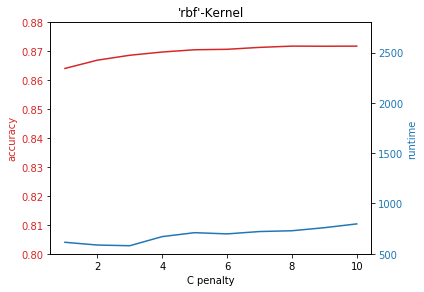

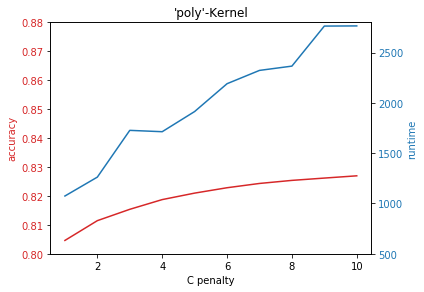

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split    # Import train_test_split function
from sklearn.model_selection import cross_val_score     # Import cross_val_score function
from sklearn import metrics                             # Import scikit-learn metrics module for accuracy calculation
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

#Computation for radial basis function Kernel
rbf_range = range(1,11)
rbf_score_results = []
rbf_runtimes = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1) # 75% training

for current_C in rbf_range:
    svc = make_pipeline(StandardScaler(), SVC(C=current_C, gamma='scale', kernel ='rbf'))

    # Train SVC
    t0 = time.clock()

    svc = svc.fit(X_train,y_train)
    y_pred = svc.predict(X_test)

    runtime = time.clock() - t0

    print("Current C value: ", current_C)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Runtime: ", runtime)
    rbf_score_results.append(metrics.accuracy_score(y_test, y_pred))
    rbf_runtimes.append(runtime)

print(rbf_score_results)
print(rbf_runtimes)

#Precomputed results
rbf_score_results = [0.86408, 0.86694, 0.86864, 0.86976, 0.87054, 0.8707, 0.87136, 0.8718, 0.87176, 0.8718]
rbf_runtimes = [614.4946727000001, 587.0297808, 580.2541574999996, 670.9205116000003, 709.9656888, 697.8248281000006, 721.2653836999998, 729.1905161999994, 759.3941573000002, 797.1693445000001]


#Computation for polynomial Kernel
poly_range = range(1,11)
poly_score_results = []
poly_runtimes = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1) # 75% training

for current_C in poly_range:
    svc = make_pipeline(StandardScaler(), SVC(C=current_C, gamma='scale', kernel ='poly'))

    # Train SVC
    t0 = time.clock()

    svc = svc.fit(X_train,y_train)
    y_pred = svc.predict(X_test)

    runtime = time.clock() - t0

    print("Current C value: ", current_C)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Runtime: ", runtime)
    poly_score_results.append(metrics.accuracy_score(y_test, y_pred))
    poly_runtimes.append(runtime)

print(poly_score_results)
print(poly_runtimes)

#Precomputed results
poly_score_results = [0.80462, 0.81146, 0.81538, 0.81874, 0.82098, 0.82284, 0.82432, 0.82538, 0.82618, 0.82696]
poly_runtimes = [1074.3855912, 1262.3066660000002, 1726.9287176999997, 1713.5205059999998, 1914.0188234999996, 2190.6926057, 2322.8306677, 2365.472538, 2763.4795562, 2765.119754399999]

#Draw rbf plots
rbf_fig, rbf_accuracy = plt.subplots()

color = 'tab:red'
rbf_accuracy.set_xlabel('C penalty')
rbf_accuracy.set_ylabel('accuracy', color=color)
rbf_accuracy.plot(rbf_range, rbf_score_results, color=color)
rbf_accuracy.tick_params(axis='y', labelcolor=color)
axes = plt.gca()
axes.set_ylim([0.8,0.88])

rbf_runtime = rbf_accuracy.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rbf_runtime.set_ylabel('runtime', color=color)  # we already handled the x-label with ax1
rbf_runtime.plot(rbf_range, rbf_runtimes, color=color)
rbf_runtime.tick_params(axis='y', labelcolor=color)
axes = plt.gca()
axes.set_ylim([500,2800])

rbf_fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("'rbf'-Kernel")
plt.show()


#Draw poly plots
poly_fig, poly_accuracy = plt.subplots()

color = 'tab:red'
poly_accuracy.set_xlabel('C penalty')
poly_accuracy.set_ylabel('accuracy', color=color)
poly_accuracy.plot(poly_range, poly_score_results, color=color)
poly_accuracy.tick_params(axis='y', labelcolor=color)
axes = plt.gca()
axes.set_ylim([0.8,0.88])

poly_runtime = poly_accuracy.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
poly_runtime.set_ylabel('runtime', color=color)  # we already handled the x-label with ax1
poly_runtime.plot(poly_range, poly_runtimes, color=color)
poly_runtime.tick_params(axis='y', labelcolor=color)
axes = plt.gca()
axes.set_ylim([500,2800])

poly_fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("'poly'-Kernel")
plt.show()

### Conclusion:
Best result on training data: 87.28%  
Best result on test data: 87.42%

In the end, the SVC seemed to achieve good results with the right configuration. The 'challenge' with this classifier was not to get it working or primarly find the optimal parameters, but keep a good balance between the runtime and possible accuracy. By choosing wrong parameters, we not only experienced a lower accuracy, but also increased the computation time in such a way, that we could not predict if the algorithm would take 3 more hours, days or months to compute. In the end, we are confident that we chose reasonable parameters and achieved a decent score in a appropiate computation time.

## 5.2 LinearSVC <a class="anchor" id="section_5_2"></a>

The LinearSVC is another implementation of a SVM, but is -as the name already implies- optimised for a linear kernel function. In contrast to the 'classic' SVC implementation by the libsvm library, the LinearSVC by the liblinear library promises to be more efficient on a large sample set, and thus fits our usecase. But as the LinearSVC provides slightly different parameters, we had to tune those parameters once again. Similar to the 'classic' SVC, we looked at the most important parameters and their different values:

- penalty (String): Defines a weight for each feature, which is applied to the loss function by adding a coefficient. It is used to find (un)important features in order to measure their importance and prevent under-/overfitting.

    - L1 regularization: Also called Lasso Regression; Can be used to completely ignore unimportant features by setting its coefficient weight near to zero. Applying L1 reg. results in a simple, low complex model.
    - L2 regularization: Also called Ridge Regression; Is robust to outliners and performs well if all features have an impact.

- loss: "A loss function maps decisions to their associated costs." (Quote from documentation)

    - hinge: "Hinge Loss not only penalizes the wrong predictions but also the right predictions that are not confident." (Quote from documentation)
    - squared_hinge: Square of the hinge loss function.

- dual (Boolean): Determines, whether to solve a dual or primal optimization problem. If the number of samples exceeds the number of features, it is said to use a primal optimization problem (False).

- tol (Float value): Defines the tolerance for a stopping criteria. If the updates of the current iteration are smaller than the defined tolerance, the algorithm terminates.

- C (Float value): Regularization Parameter to set the penalty for a false classification. A high penalty leads to a more complex model, but may result in overfitting. With a low penalty, some data points may be classified wrong (Similar to the 'classic' SVC).

As the LinearSVC has a shorter runtime, we could have used BayesSearch to just test different parameter configurations in order to find the optimal hyperparameters. But as it turns out, many parameter combinations are not supported by the implementation. As a consequence, we searched for the optimal hyperparameters manually. We began by figuring out the best options for the first three listed parameters, as the last two parameters are float values which could be optimised afterwards.

As the L1 regularization penalty allows the SVC to discard unimportant features, we expected a smaller accuracy (due to a low complex model), but a smaller runtime too. For L1, the implementation just allows the 'squared_hinge' loss function and the computation as a primal optimization problem (dual=False). As the number of our samples exceeded the number of features, we would have wanted to use the primal optimization problem anyway. We scored an accuracy of 72.95% in 2.67 seconds. As expected, the LinearSVC was very fast, especially in comparison to the 'classic' SVC. But, the accuracy dropped rapidly too.

Therefore, we tried to use the L2 regularization, as we hoped for a more complex model (all features are used) and a better accuracy. Meanwhile, we wanted to stick to the primal optimization as before. But as it comes to the 'hinge' loss function, only the dual optimization is supported, we therefore had to change the parameter in this configuration. We achieved the following results:

`{penalty='l2', loss='squared_hinge', dual=False}` : An accuracy of 72.95% in 0.98 seconds.


`{penalty='l2', loss='hinge', dual=True}` : An accuracy of 74.58% in 20.08 seconds.

We assume that the first configuration runs so much quicker due to the primal instead of the dual optimization parameter option, but as the second one scored better by roughly 1.6%, we proceeded with those parameters. As it comes to the tolerance and 'C' value, we tried to increase the accuracy further. The idea was to increase the 'C' value (from default 1.0), and decrease the tolerance (from default 1e-4) in order to get a more complex model. As expected, the runtime increased due to the complexity, but the accuracy stayed the same to a 1/10 percent. Therefore, we sticked to the default parameter values in the end, and got our final configuration:  
>`{penalty='l2', loss='hinge', dual=True, tol=1e-4, C=1.0}`.

Sources:  
- [L1 and L2 Regularization](https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2)  
- [L1 and L2 Regularization Methods](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)  
- [A Detailed Guide to 7 Loss Functions for Machine Learning Algorithms with Python Code](https://www.analyticsvidhya.com/blog/2019/08/detailed-guide-7-loss-functions-machine-learning-python-code/)  
- [Documentation for LinearSVClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)  
- [What exactly is tol (tolerance) used as stopping criteria in sklearn models?](https://stats.stackexchange.com/questions/255375/what-exactly-is-tol-tolerance-used-as-stopping-criteria-in-sklearn-models)

In [7]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import metrics                              # Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import train_test_split     # Import train_test_split function
from sklearn.model_selection import cross_val_score      # Import cross_val_score function
from sklearn.model_selection import KFold  # Import utilities
from sklearn.externals import joblib

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

# Create LinearSVClassifier object
linsvc = make_pipeline(StandardScaler(),
                    LinearSVC(penalty='l2', loss='hinge', dual=True, max_iter=500000))


# ------------ SIMPLE SPLIT ------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1) # 75% training
t0 = time.clock()

# Train LinearSVC
linsvc = linsvc.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = linsvc.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Runtime: ", time.clock() - t0)
# ------------ SIMPLE SPLIT ------------


# # ---------- CROSS VALIDATION ---------
kf = KFold(n_splits=5, shuffle=False, random_state=0)
t0 = time.clock()
scores = cross_val_score(linsvc, X, y, cv=kf) #Params: Classifier, features, target/label, repetition
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Runtime: ", time.clock() - t0)
# ---------- CROSS VALIDATION ---------


# --------- PREDICT ON TESTDATA --------
linsvc = linsvc.fit(X,y)
y_pred = linsvc.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

Accuracy: 0.74213
Runtime:  13.12015109999993


### In-depth look at some hyperparameters

For a better look at how the different hyperparameters affect the accurancy of the LinearSVC we generated some plots. We focused on the 'C' penalty and tolerance ('tol') parameters, as the other parameters were already specified before or did not have any effect on the kernel (see above).

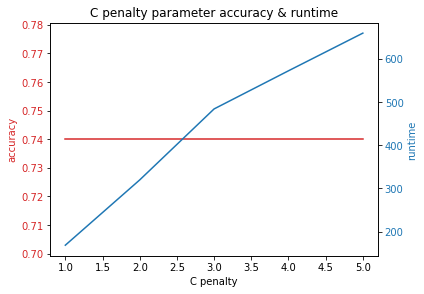

In [8]:
from sklearn.svm import LinearSVC
from sklearn import metrics                              # Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_score      # Import cross_val_score function
from sklearn.model_selection import KFold  # Import utilities
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

C_range = range(1, 6)
C_score_results = []
C_runtimes = []

for current_C in C_range:
    linsvm = make_pipeline(StandardScaler(), LinearSVC(penalty='l2', loss='hinge', dual=True, C=current_C, max_iter=500000))

    kf = KFold(n_splits=5, shuffle=False, random_state=0)
    t0 = time.clock()
    scores = cross_val_score(linsvm, X, y, cv=kf) #Params: Classifier, features, target/label, repetition
    runtime = time.clock() - t0

    print("Current C value: ", current_C)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Runtime: ", runtime)
    C_score_results.append(scores.mean())
    C_runtimes.append(runtime)

#Precomputed results
C_score_results = [0.74, 0.74, 0.74, 0.74, 0.74]
C_runtimes = [168.97173810000004, 319.77986039999996, 483.80762559999994, 571.9154522999997, 658.9240537000001]


#Draw plots
fig, C_accuracy = plt.subplots()

color = 'tab:red'
C_accuracy.set_xlabel('C penalty')
C_accuracy.set_ylabel('accuracy', color=color)
C_accuracy.plot(C_range, C_score_results, color=color)
C_accuracy.tick_params(axis='y', labelcolor=color)

C_runtime = C_accuracy.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
C_runtime.set_ylabel('runtime', color=color)  # we already handled the x-label with ax1
C_runtime.plot(C_range, C_runtimes, color=color)
C_runtime.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("C penalty parameter accuracy & runtime")
plt.show()

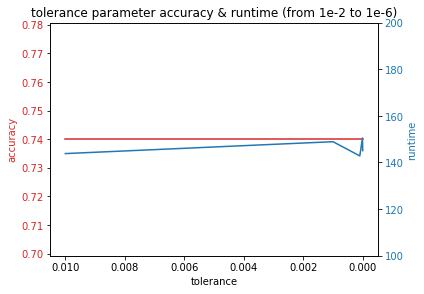

In [17]:
from sklearn.svm import LinearSVC
from sklearn import metrics                              # Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_score      # Import cross_val_score function
from sklearn.model_selection import KFold  # Import utilities
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

tol_range = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
tol_score_results = []
tol_runtimes = []

for current_tol in tol_range:
    linsvm = make_pipeline(StandardScaler(), LinearSVC(penalty='l2', loss='hinge', dual=True, tol=current_tol, max_iter=500000))

    kf = KFold(n_splits=5, shuffle=False, random_state=0)
    t0 = time.clock()
    scores = cross_val_score(linsvm, X, y, cv=kf) #Params: Classifier, features, target/label, repetition
    
    tol_runtime = time.clock() - t0

    print("Current tol value: ", current_tol)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Runtime: ", tol_runtime)
    tol_score_results.append(scores.mean())
    tol_runtimes.append(tol_runtime)

#Precomputed results
tol_score_results = [0.74, 0.74, 0.74, 0.74, 0.74]
tol_runtimes = [143.8184584999999, 148.91489389999992, 142.82644059999984, 150.48350660000006, 145.0758925]


#Draw plots
fig, tol_accuracy = plt.subplots()

color = 'tab:red'
tol_accuracy.set_xlabel('tolerance')
tol_accuracy.set_ylabel('accuracy', color=color)
tol_accuracy.plot(tol_range, tol_score_results, color=color)
tol_accuracy.tick_params(axis='y', labelcolor=color)

tol_runtime = tol_accuracy.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
tol_runtime.set_ylabel('runtime', color=color)  # we already handled the x-label with ax1
tol_runtime.plot(tol_range, tol_runtimes, color=color)
tol_runtime.tick_params(axis='y', labelcolor=color)
axes = plt.gca()
axes.set_ylim([100,200])
axes.invert_xaxis()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("tolerance parameter accuracy & runtime (from 1e-2 to 1e-6)")
plt.show()

### Conclusion:

Best result on training data:       74.58%  
Best result on test data:           74.88%

By using the LinearSVC, we again witnessed the accuracy/runtime tradeoff we already experienced for the 'classic' SVC. In general, the LinearSVC seems to be better optimized for larger sample sets (as expected) and is more friendly to use. But on the other hand, it scores at a much lower accuracy in comparison to other classifiers, although the SVC is expected to be a very well designed, complex classifier with a high accuracy. We assume the reason lies in our sample/feature set; we think that the sample set is not linearly separable based on our feature set. Therefore, a linear SVC kernel can not exploit the whole potential of the SVC. Although we chose the optimal hyperparameters, the accuracy did only improve by 1.5% (penalty-, loss- and dual-parameter) and from there on did not improve at all (as the plots for the hyperparameter configurations show).

---
# 6 Random Forest Classification <a class="anchor" id="chapter6"></a>

## 6.1 'Classic' Random Forest Classification <a class="anchor" id="section_6_1"></a>

Random Forest Classification uses multiple, uncorrelated decision trees (as explained above). Those decision trees were build within different subsets of the training data. The Classification of a data sample is made by those decision trees, as the majority decides about its classification. Since individual decision trees are uncorrelated, Random Forest Classification enables a simultaneous training of its decision trees, which makes it faster than other classification techniques (the time needed to train the decisions trees ascends linearly with the number of trees). It is efficient für big amounts of data (in our case many training labels).

As the foundation of the parameter tuning serves a manual comparison of train_test_split, kFold-cv and skFold-cv (each with 20 to 500 estimators). Train_Test_Split led to average accuracies from 85.40% to 86.22%, while kFold-cv led to average accuracies from 85.49% to 86.34% and skFold-cv to 85.40% to 86.36%. Overall, the precision improved the most with raising the estimators to 200. After that, there is no noticeable improvement to record. The improvement from train_test_split to kFold-cv averages 0.1%, while the improvement from kFold-cv to skFold-cv (Stratified KFold) only averages 0.02%. Note: All of this results are from the RandomForestClassifier without adjustments (therefore, default parameters).

In the next step, we tried to get a feeling for which parameters to tune. We did this by using RandomizedSearchCV multiple times. RandomizedSearchCV allows us to choose some constant values and ranges, in which will be randomly searched for the best parameter configurations. The advantage towards GridSearchCV/BayesSearch is that it provides good results in short time, as opposed to 'perfect' results in much longer time. So, RandomziedSearchCV is a good approach to get initial reference points. The best results were achieved by the configurations 
>`{n_estimator =150, bootstrap = False, max_features = 'auto'}` &  
>`{n_estimator =150, bootstrap = False, max_features = 2}`.  

The other values did not vary from the default values of the RandomForestClassifier.

Afterwards, we did a little parameter tuning with the help of GridSearchCV (as explained above) and manual testing of different parameters. Most parameter modifications were unsuccessful (as max_depth, ccp_alpha, criterion, min_samples_split or min_samples_leaf), so they remained default. We found out that the best accuracy could be achieved by using the following configuration (only those parameters which are different than their default value):  
>`{bootstrap = False, n_estimators = 150, max_features = 2}`. (Note: max_features = 2 is clearly superior to max_features = 'auto').  

Although choosing a higher n_estimators led to a slightly higher accuracy, it was not significantly better, considering performance deficits. This parameter configuration led to an average accuracy of 86.40%, while the highest scores tended to 86.90%. This results are based on the (default) kFold Cross Validation with n_split = 5. Increasing n_split also led to slightly better results, but considering its performance it is not worth it.

A more detailed comparison of kFold and skFold showed insignificant accuracy advantages in favor of skFold. While KFold only splits the data into k random folds, Stratified KFold is also making sure each fold is an appropriate representative of the original data. Since both Cross Validations do not distinguish significantly from each other in terms of accuracy, we will continue to use KFold-cv as our preferred Cross Validation.

The last issue we reviewed is whether shuffling the data leeds to increasing the accuracy of the classifier. To check this, we compared KFold-cv for k = 3 to k = 10 with shuffle = True/False. For n_split (k) less equal than 5, there was no improvement of accuracy. But with increasing n_split, the accuracy became slightly better. So, for n_split greater equal than 7, it can be useful to set shuffle = True. But, since we decided to use n_split = 5, it is not relevant to our classifier.

Sources:
- [Overview of RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  
- [Implementing a Random Forest Classification Model in Python](https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652)  
- [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)  
- [How to develop a Random Forest Ensemble in Python](https://machinelearningmastery.com/random-forest-ensemble-in-python/)

In [5]:
#Load Libraries
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.model_selection import cross_val_score # Import cross_val_score function
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold # Import Utilities

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

In [6]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators=150,max_features=2,bootstrap=False)
clf1 = RandomForestClassifier(n_estimators=100,max_features=8,max_depth=15,criterion='gini',bootstrap=True)
clf2 = RandomForestClassifier(n_estimators=200,max_features=2,bootstrap=False)
#clf.get_params().keys() -> Identify the parameters

In [ ]:
# Validation Procotol: Train Test Split

#Preparing Data For Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Train Random Forest Classifer
clf2.fit(X_train, y_train)
# Predict the response for test dataset
y_pred = clf2.predict(X_test)
# Evaluating the Algorithm
print(accuracy_score(y_test, y_pred))

In [7]:
# ---------- CROSS VALIDATION ----------
skf = StratifiedKFold(n_splits=2)
kf = KFold(n_splits=5) #zusätzlich mit shuffle=True zum Vergleich ausführen
scores = cross_val_score(clf, X, y, cv=kf, n_jobs=-1) #Params: Classifier, features, target/label, repetitions
print(scores)
print("Accuracy: %0.5f" % (scores.mean()))
# ---------- CROSS VALIDATION ----------

[0.8622   0.8643   0.866425 0.864    0.863275]
Accuracy: 0.86404


In [ ]:
# ----------- Hypterparameter Tuning per Zufall (RandomizedSearchCV) -----------
random_grid = {"bootstrap":[False],"n_estimators":[150,200],"max_features":[2]}
# Standard-Parameter cv = KFold(n_splits=5)
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 20, n_jobs = -1)
rf_random.fit(X=X,y=y)
print(rf_random.best_score_, rf_random.best_params_)

In [ ]:
# ----------- Hypterparameter Tuning -----------
# attempt to find best parameters for the random forest
param_grid = {"bootstrap":[False],"max_features":['auto',2],"n_estimators":[150]}
grid_clf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, n_jobs=-1)
grid_clf.fit(X=X, y=y)
#rf_model = grid_clf.best_estimator_
print(grid_clf.best_score_, grid_clf.best_params_)
#print(grid_clf.cv_results_)
# ----------- Hypterparameter Tuning -----------

In [ ]:
#Comparison of Shuffle = True and Shuffle = False
clftest = RandomForestClassifier(n_estimators=150,max_features=2,bootstrap=False)
kftest5 = KFold(n_splits=5)
kftest7 = KFold(n_splits=7)
kftest5s = KFold(n_splits=5,shuffle=True)
kftest7s = KFold(n_splits=7,shuffle=True)

kfscore = cross_val_score(clftest, X, y, cv=kftest5, n_jobs=-1)
print(kfscore)
print("Accuracy KFold 5-Split: %0.5f" % (kfscore.mean()))

kfscores = cross_val_score(clftest, X, y, cv=kftest5s, n_jobs=-1)
print(kfscores)
print("Accuracy KFold 5-Split Shuffle: %0.5f" % (kfscores.mean()))

In [ ]:
#Comparison of KFold and SKFold + Shuffle
testclassifier150 = RandomForestClassifier(n_estimators=150,max_features=2,bootstrap=False)
testclassifier175 = RandomForestClassifier(n_estimators=175,max_features=2,bootstrap=False)
testclassifier200 = RandomForestClassifier(n_estimators=200,max_features=2,bootstrap=False)
kf10 = KFold(n_splits=10)
skf10 = StratifiedKFold(n_splits=10)

#KFold mit k=10
kf10score = cross_val_score(testclassifier150, X, y, cv=kf10, n_jobs=-1)
print(kf10score)
print("Accuracy KFold 10-Split, n=150: %0.5f" % (kf10score.mean()))

#StratifiedKFold mit k=10
skf10score = cross_val_score(testclassifier150, X, y, cv=skf10, n_jobs=-1)
print(skf10score)
print("Accuracy SKFold 10-Split, n=150: %0.5f" % (skf10score.mean()))

In [ ]:
#Comparison of KFold und StratifiedKFold
testclassifier = RandomForestClassifier(n_estimators=150,max_features=2,bootstrap=False)

#StratifiedKFold mit k=3/5/7
skf = StratifiedKFold(n_splits=3) #5/7
skfscore = cross_val_score(testclassifier, X, y, cv=skf, n_jobs=-1)
print(skf3score)
print("Accuracy SKFold 3-Split: %0.5f" % (skfscore.mean()))

#KFold mit k=3
kf = KFold(n_splits=3) #5/7
kfscore = cross_val_score(testclassifier, X, y, cv=kf, n_jobs=-1)
print(kfscore)
print("Accuracy KFold 3-Split: %0.5f" % (kfscore.mean()))

In [28]:
# --------- PREDICT ON TESTDATA --------
clf = clf.fit(X,y)
y_pred = clf.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

{'score': 0.866}

### In-depth look at some hyperparameters

For a better look at how the different hyperparameters affect the accurancy of the random forest we generated some plots. We chose to set the other parameters to the values that had the best performance in the GridSearch/RandomizedSearch (see above).

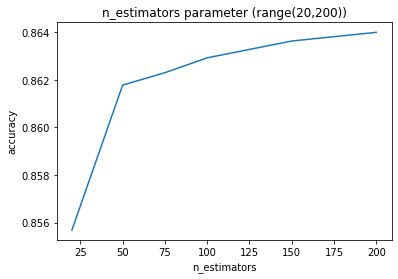

In [17]:
depths = [20,50,75,100,150,200]
score_results = []

for depth in depths:
    rfc = RandomForestClassifier(n_estimators=depth,max_features=2,bootstrap=False)
    kf = KFold(n_splits=5)
    scores = cross_val_score(rfc, X, y, cv=kf,n_jobs=-1) #Params: Classifier, features, target/label, repetitions
    score_results.append(scores.mean())

plt.title("n_estimators parameter (range(20,200))")
plt.plot(depths, score_results, label="scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.show()

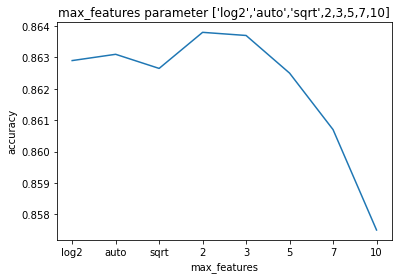

In [15]:
depths = ['log2','auto','sqrt',2,3,5,7,10]
score_results = []

for depth in depths:
    rfc = RandomForestClassifier(n_estimators=150,max_features=depth,bootstrap=False)
    kf = KFold(n_splits=5)
    scores = cross_val_score(rfc, X, y, cv=kf,n_jobs=-1) #Params: Classifier, features, target/label, repetitions
    score_results.append(scores.mean())

# pre-computed data
score_results = [0.8629,0.8631,0.86265,0.8638,0.8637,0.8625,0.8607,0.8575]

plt.title("max_features parameter ['log2','auto','sqrt',2,3,5,7,10]")
plt.plot(depths, score_results, label="scores")
plt.ylabel("accuracy")
plt.xlabel("max_features")
plt.show()

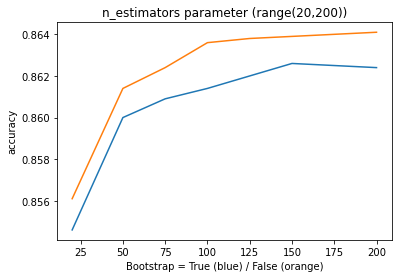

In [23]:
depths = [20,50,75,100,125,150,175,200]
score_results_bootstrap_true = []
score_results_bootstrap_false = []

#Bootstrap = True
for depth in depths:
    rfc = RandomForestClassifier(n_estimators=depth,max_features=2,bootstrap=True)
    kf = KFold(n_splits=5)
    scores = cross_val_score(rfc, X, y, cv=kf, n_jobs=-1) #Params: Classifier, features, target/label, repetitions
    score_results_bootstrap_true.append(scores.mean())

#Bootstrap = False
for depth in depths:
    rfc = RandomForestClassifier(n_estimators=depth,max_features=2,bootstrap=False)
    kf = KFold(n_splits=5)
    scores = cross_val_score(rfc, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
    score_results_bootstrap_false.append(scores.mean())

# pre-computed data
score_results_bootstrap_true = [0.8546,0.86,0.8609,0.8614,0.862,0.8626,0.8625,0.8624]
score_results_bootstrap_false = [0.8561,0.8614,0.8624,0.8636,0.8638,0.8639,0.864,0.8641]

plt.title("n_estimators parameter (range(20,200))")
plt.plot(depths, score_results_bootstrap_true, label="scores")
plt.plot(depths, score_results_bootstrap_false, label="scores")
plt.ylabel("accuracy")
plt.xlabel("Bootstrap = True (blue) / False (orange)")
plt.show()

### Conclusion

Best result on training data:  86.86%  
Best result on test data:      86.60%

The Random Forest, as it uses many Decision Trees, is a simple but effective extension of a Decision Tree. Once we found a good parameter configuration, we were able to improve our accuraccy significantly with this classifier. Figuring out which parameters to tune and in which way was the hardest part of dealing with the Random Forest classifier. With increasing the amount of decision trees it clearly was stretched to its limit (as seen above), but overall the classifier worked out pretty well.

# 6.2 XGBoost <a class="anchor" id="section_6_2"></a>

We also wanted to try **XGBoost** as it is a very common classifier that was able to succeed in many ML-competitions. XGBoost is a very well optimized and highly scalable gradient boost framework. A gradient boost approach uses a number of _weak_ classifiers and combines them into a _stronger_ classifier. We will not go into further detail as the [glossary entry](https://moodle.tu-dortmund.de/mod/glossary/view.php?id=536016&mode=letter&hook=G&sortkey=&sortorder=) is quite detailed.  

In our tests we were able to achieve good results in really short amounts of time. 

Results of parameter tuning with BayesSearchCB: 
> `0.872165 OrderedDict([('alpha', 3), ('booster', 'dart'), ('colsample_bytree', 0.7), ('gamma', 0.4), ('importance_type', 'gain'), ('lambda', 1), ('learning_rate', 0.2), ('max_delta_step', 0), ('max_depth', 14), ('min_child_weight', 16), ('sampling_method', 'gradient_based'), ('tree_method', 'hist')])`

In [6]:
# this section will need the xgboost (XGBClassifier) and skopt (for BayesSearchCV) packages:
#   skopt:  conda install -n fp -c conda-forge scikit-optimize
#   xgboost: conda install -n fp -c conda-forge xgboost 
#        OR: pip install xgboost 

from xgboost import XGBClassifier                       # Import XGBoost Classifier
from sklearn.model_selection import cross_val_score     # Import cross_val_score function
from sklearn.model_selection import KFold               # Import KFold
from skopt import BayesSearchCV                         # Import BayesSearchCB (more optimised than GridSearchCV)
from xgboost import plot_tree
import matplotlib.pyplot as plt

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels


# --------------- PARAMETER TEST XGBOOST ---------------
# attempt to find best parameters for XGBoost
parameters = {  "max_depth":[x for x in range(3,17)],
                "learning_rate":[0.0001,0.001,0.01,0.1,0.15,0.2,0.25,0.3,1.0,10.0],
                "booster":["gbtree","gblinear","dart"],
                "gamma":[0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.7,1,10.0],
                "importance_type":["gain","weight","cover","total_gain","total_cover"],
                "tree_method":["auto","approx","hist","gpu_hist"],
                "min_child_weight":[1,3,5,7,9,12,16],
                "colsample_bytree":[0.1,0.2,0.3,0.4,0.5,0.6,0.7],
                "max_delta_step":[x for x in range(0,10)],
                "sampling_method":["uniform","gradient_based"],
                "lambda":[x for x in range(1,5)],
                "alpha":[x for x in range(0,5)]}

xgb = BayesSearchCV(XGBClassifier(),parameters)
xgb.fit(X=X,y=y)
print(xgb.best_score_, xgb.best_params_) 
# --------------- PARAMETER TEST XGBOOST ---------------


# Create XGBClassifier object
xgb = XGBClassifier(alpha=3, booster="dart", colsample_bytree=0.7, gamma=0.4, importance_type="gain", reg_lambda=1, learning_rate=0.2, max_delta_step=0, max_depth=14,min_child_weight=16, sampling_method="gradient_based", tree_method="hist")

# -------------- CROSS VALIDATION XGBOOST --------------
kf = KFold(n_splits=5, shuffle=False, random_state=2652124)
scores = cross_val_score(xgb, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
print("Accuracy XGBoost: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# -------------- CROSS VALIDATION XGBOOST --------------


# --------- PREDICT ON TESTDATA --------
xgb = xgb.fit(X,y)
y_pred = xgb.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

Accuracy XGBoost: 0.87 (+/- 0.00)


{'score': 0.8736}

### In-depth look at decision trees

The weak classifiers that are combined by the XGBClassifier are usually decision trees. We tried to visualize one of the decision trees, which is shown below.

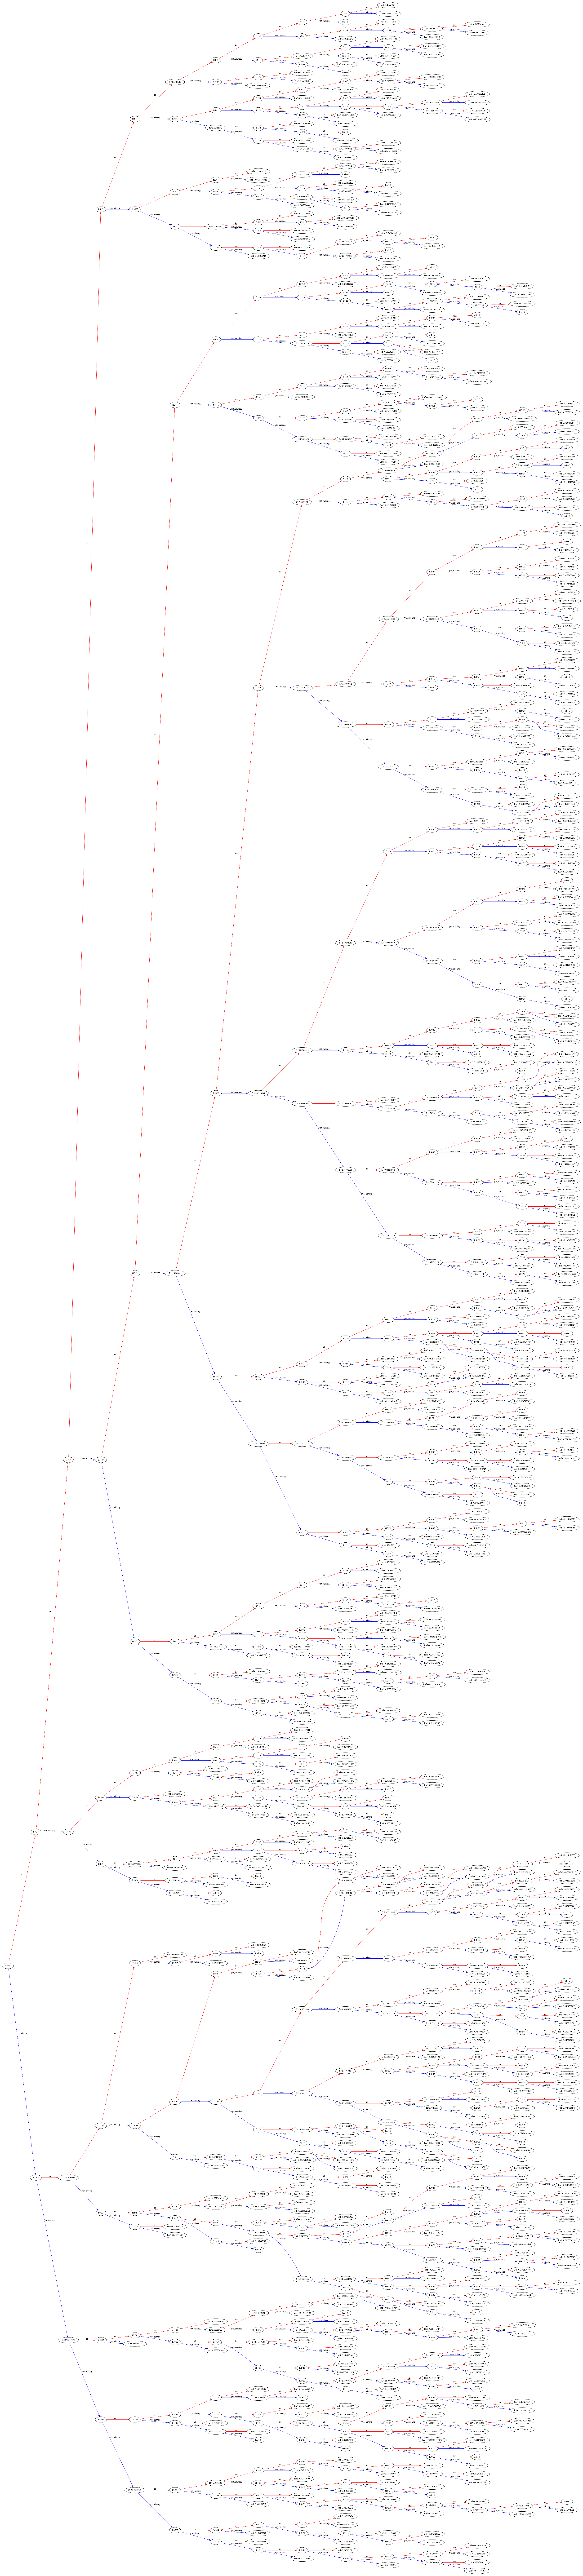

In [12]:
from xgboost import XGBClassifier                       # Import XGBoost Classifier
from sklearn.model_selection import cross_val_score     # Import cross_val_score function
from sklearn.model_selection import KFold               # Import KFold
from skopt import BayesSearchCV                         # Import BayesSearchCB (more optimised than GridSearchCV)
from xgboost import plot_tree
import matplotlib.pyplot as plt


# Create XGBClassifier object
xgb = XGBClassifier(alpha=3, booster="dart", colsample_bytree=0.7, gamma=0.4, importance_type="gain", reg_lambda=1, learning_rate=0.2, max_delta_step=0, max_depth=14,min_child_weight=16, sampling_method="gradient_based", tree_method="hist")

xgb.fit(X,y)

plot_tree(xgb, num_trees=1, rankdir="LR")
fig = plt.gcf()
fig.set_size_inches(150, 200)

### Conclusion

Best result on training data: 87%  
Best result on test data: 87.36%

We experienced the XGBoost-Framework as an easy-to-use second approach to Random Forest Classsifiers. As we expected it to be more optimised than the 'classic' implementation, we were hoping to achieve higher accuracies, which we did. Nevertheless, as the improvement was just about 1%, we presume that the performance is limited by the information which are provided by our extracted feature set.

---
# 7 Neural network - multilayer perceptron

A multilayer perceptron is a feedforward (artificial) neural network. It consists of an input layer, (one or multiple) hidden layers and an output layer. Each layer is built from multiple neurons/perceptron which have multiple weighted inputs and are connected to the next layer. Based on the inputs the neurons can compute an output and propagate that value to the inputs of the neurons in the next layer. A simplified explanation of the process is that each neuron can either be on (activated) or off. The switching of the neurons directly affects the switching in the next layer and therefore also the end result.   

An example for the use of the combination of multiple neurons is the XOR-problem. A single neuron is capable of linear classifications and can easily represent the AND- & OR-function. But with only one seperating line it is not possible to model the XOR-function. So a single neuron can't represent the XOR-function. This is where neural networks come in: a combination of multiple neurons (NAND and OR as input layer neurons followed by AND as the ouput layer) can be used to classify the XOR-function. 

So as we have seen, multiple layers of neurons can be used for classification problems of increased complexity. The multilayer perceptron for our setting needs to have 16 input layers (number of features) and 2 ouput layers (1 or 0 as the prediction). In theory, the learning process of multilayer perceptrons works by backpropagation. In each iteration of the supervised learning (so for each piece of data processed) the amount of error in the ouput is used to adjust the weights of the connections between the neurons. In the end the weights represent the importance of the neuron to the resulting decision. For our first tests we took a look at the __MLPClassifier__ from __scikit-learn__. It has a huge amount of adjustable parameters: for example the number of layers and the number of neurons in each layer can be adjusted. 

The result of the hyperparameter tuning with BayesSearchCV was: 
> `0.84947 OrderedDict([('activation', 'relu'), ('alpha', 1e-05), ('beta_1', 0.7), ('beta_2', 0.999), ('learning_rate', 'constant'), ('learning_rate_init', 0.001), ('max_iter', 700), ('solver', 'adam')])`

We were not able to incorporate the `hidden_layer_sizes` parameter into the automated parameter tuning due to random errors so we had to run manual tests. In these tests it became clear that it is of no benefit to increase the amount of neurons in each layer to "infinity" as it leads to an overfitting of the network. We also found out that the fairly big amounts of data we need to process led to very long runtimes. In the results we could also see that a deeper neural network (see below) was able to produce better results than networks with only one hidden layer. In the end we were able to achieve accurancys of about 0.89. 

sources:
- [Overview of MLP](https://missinglink.ai/guides/neural-network-concepts/perceptrons-and-multi-layer-perceptrons-the-artificial-neuron-at-the-core-of-deep-learning/)
- [Documentation for MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
- [Uni Freiburg slides on NNs and MLP](http://ml.informatik.uni-freiburg.de/former/_media/documents/teaching/ss09/ml/mlps.pdf)
- [Simple explanation of XOR-problem](https://www.inf-schule.de/gesellschaft/kuenstliche-intelligenz/xor_problem)

In [ ]:
# this section will need the skopt (for BayesSearchCV) package:
#   skopt:  conda install -n fp -c conda-forge scikit-optimize

from sklearn.model_selection import cross_val_score     # Import cross_val_score function
from sklearn.model_selection import KFold               # Import KFold
from skopt import BayesSearchCV                         # Import BayesSearchCB (more optimised than GridSearchCV)
from sklearn.neural_network import MLPClassifier        # Import MLPClassifier
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

# --------------- PARAMETER TEST MLP ---------------
attempt to find best parameters for MLPClassifier (Multi-layer perceptron)
parameters = {    "activation": ["tanh", "relu"],
                    "solver": ["sgd", "adam"],
                    "alpha": 10.0 **-np.arange(1, 7),
                    "learning_rate": ["constant", "adaptive"],
                    "learning_rate_init": [0.0001,0.001,0.01],
                    "max_iter": [150,200,300,500,700],
                    "beta_1": [0.7,0.9],
                    "beta_2": [0.7,0.8,0.999]
             }

mlp = BayesSearchCV(MLPClassifier(),parameters)
mlp.fit(X=X,y=y)
print(mlp.best_score_, mlp.best_params_) 
joblib.dump(mlp, "mlpV1.pkl")
# --------------- PARAMETER TEST MLP ---------------


mlp = MLPClassifier(activation="relu", alpha=1e-06, beta_1=0.7, beta_2=0.999, learning_rate="constant", learning_rate_init=0.001, solver="adam",
                    hidden_layer_sizes=(128,64,32,16,8,4,), max_iter=700)


# ------------ SIMPLE SPLIT ------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

loaded_mlp = joblib.load("mlp.pkl")
print("model loaded")
# ------------ SIMPLE SPLIT ------------


# -------------- CROSS VALIDATION MLP --------------
kf = KFold(n_splits=5, shuffle=False, random_state=2652124)
scores = cross_val_score(mlp, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
print("Accuracy MLP: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# -------------- CROSS VALIDATION MLP --------------


# --------- PREDICT ON TESTDATA --------
mlp = mlp.fit(X,y)
y_pred = mlp.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

For the structure of the MLP - especially the layer size and amount - we were not able to find a common opinion in research. We chose 16 as the number of neurons in each layer as that is also the amount of features we have computed.   
#### manual tests for `hidden_layer_sizes`

In [8]:
layer_sizes = [(128,64,32,16,8,4,), (64,64,32,16,16,8,8,4,), (64,32,16,16,8,4,), (64,32,16,8,4,), (16,16,16,16,16,16,), (16,16,16,16,), (16,16,), (16,)]
score_results = []

for layers in layer_sizes:
    mlp = MLPClassifier(activation="relu", alpha=1e-06, beta_1=0.7, beta_2=0.999, learning_rate="constant", learning_rate_init=0.001,                                                                       solver="adam", hidden_layer_sizes=layers, max_iter=700)
    kf = KFold(n_splits=5)
    scores = cross_val_score(mlp, X, y, cv=kf) #Params: Classifier, features, target/label, repetitions
    score_results.append(scores.mean())

# pre-computed data
score_results = [0.8633749999999999, 0.7911699999999999, 0.787185, 0.787505, 0.8483, 0.855855, 0.8426600000000001, 0.8247099999999999]
import pandas as pd
data = np.stack((layer_sizes, score_results), axis=1)
pd.DataFrame(data, columns=["hidden_layer_sizes", "accuracy"])


hidden_layer_sizes  accuracy
0        (128, 64, 32, 16, 8, 4)  0.863375
1  (64, 64, 32, 16, 16, 8, 8, 4)   0.79117
2         (64, 32, 16, 16, 8, 4)  0.787185
3             (64, 32, 16, 8, 4)  0.787505
4       (16, 16, 16, 16, 16, 16)    0.8483
5               (16, 16, 16, 16)  0.855855
6                       (16, 16)   0.84266
7                          (16,)   0.82471

### Conclusion:

Best result on training data:       89%  
Best result on test data:           87.58%

As we have not worked with Neural Networks before, we were slighty overwhelmed by the architecture and complexity of the MLP in the beginning. Luckily -just like for the most other classifiers- a full implementation was already given in the library scikit-learn. Therefore, we did not have to deal with each layer functionality in detail and could fully focus on parameters like the size of the hidden layers (although we did not find a clear 'optimal' size). At first, we were confident about the accuracy, as we scored 89% on the training data. But as it turns out, the model seemed to be slighty overfitted in the end, as the result on the test data shows. Although we tried to optmize the training process, we could not improve the accuracy score in the end.

---
# 8 Neural network - Tensorflow <a class="anchor" id="chapter8"></a>

In [ ]:
import keras
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
classifier = keras.Sequential ([
    keras.layers.Dense(units=8,input_shape=(16,)), #Flatten, input_shape=(28,28)
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax') #sigmoid
])

In [ ]:
X = np.load('trainingdata_features.npy')
#X_test = preprocessing.scale(np.load('trainingdata_features.npy'))
#X_test = preprocessing.normalize(X, norm='l2')
#min_max_scaler = preprocessing.MinMaxScaler()
#max_abs_scaler = preprocessing.MaxAbsScaler()
#X_test = min_max_scaler.fit_transform(X)
#X_test = max_abs_scaler.fit_transform(X)
y = np.load('labels.npy')
classifier.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=["accuracy"])
#classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(X,y,batch_size=32,epochs=20,shuffle=True,validation_split=0.1,verbose=1)

In [ ]:
kf = KFold(n_splits=5)
kfscore = cross_val_score(classifier, X, y, cv=kf, n_jobs=-1)
print(kfscore)
print("Accuracy: %0.5f" % (kfscore.mean()))

In [ ]:
testdata_features = np.load("testdata_features.npy")
trainingdata_labels   = np.load("labels.npy")
y_pred = classifier.predict(testdata_features)
# Evaluating the Algorithm
print(y_pred)
print("Accuracy: %0.5f" % (y_pred.mean()))

### Conclusion:

Despite showing promising progress in terms of accuraccy within the training epochs, the classifier was not able to perform better than MLP. Data preprocessing improved the classifier slightly, but not as much as we hoped it would do. So, ultimately we decided to stick with MLP.

---
# 9 Ensemble learning / Custom classifier combination <a class="anchor" id="chapter9"></a>
Since increased runtime is not a problem for this project we had the idea to combine some of our best classifiers. We implemented two ways of combining the predictions - "voting" and based on another Multilayer perceptron. The idea was to get rid of individual mistakes of the classifiers. After that we found out about the `Stacking Classifier` from the scikit library which looked like exactly what we were looking for.

The first step of our approach is to compute the prediction arrays from the chosen classifiers. Our classifiers with the best results are: `MLPClassifier, XGBClassifier, SupportVectorClassifier and RandomForestClassifier`. It might be benefitial to increase the number of used classifiers.

In [3]:
# Import Models & Utilities
from xgboost import XGBClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split    
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics  
from sklearn.metrics import classification_report, confusion_matrix

## 9.1 Prepare Classifiers <a class="anchor" id="section_9_1"></a>

### XGBoost classifier

In [4]:
X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1) # 75% training

In [5]:
X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels


xgb = XGBClassifier(alpha=3, booster="dart", colsample_bytree=0.7, gamma=0.4, importance_type="gain", reg_lambda=1, learning_rate=0.2, max_delta_step=0, max_depth=14,min_child_weight=16, sampling_method="gradient_based", tree_method="hist")
xgb.fit(X=X_train, y=y_train)
clf1_pred_arr = xgb.predict(X_test)

print("xgb classifier")
print("-------------------------------------")
print(confusion_matrix(y_test,clf1_pred_arr))
print(classification_report(y_test,clf1_pred_arr))
print("-------------------------------------")

clf1_pred_arr = xgb.predict(X)

xgb classifier
-------------------------------------
[[22479  2513]
 [ 3953 21055]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     24992
           1       0.89      0.84      0.87     25008

    accuracy                           0.87     50000
   macro avg       0.87      0.87      0.87     50000
weighted avg       0.87      0.87      0.87     50000

-------------------------------------


### Random forest classifier

In [6]:
rf = RandomForestClassifier(n_estimators=250, min_samples_split=20, min_samples_leaf=1, max_features="sqrt", max_depth=None, bootstrap=False)
rf.fit(X=X_train, y=y_train)
clf2_pred_arr = rf.predict(X_test)

print("rf classifier")
print("-------------------------------------")
print(confusion_matrix(y_test,clf2_pred_arr))
print(classification_report(y_test,clf2_pred_arr))
print("-------------------------------------")

clf2_pred_arr = rf.predict(X)

rf classifier
-------------------------------------
[[22181  2811]
 [ 4137 20871]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     24992
           1       0.88      0.83      0.86     25008

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighted avg       0.86      0.86      0.86     50000

-------------------------------------


### Multilayer perceptron

In [7]:
X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels


mlp = MLPClassifier(activation="relu", alpha=1e-06, beta_1=0.7, beta_2=0.999, learning_rate="constant", learning_rate_init=0.001, solver="adam", 
                    hidden_layer_sizes=(16,16,16,16,16,16,), max_iter=700)
                    
scaler = StandardScaler()
scaler.fit(X)
X2 = scaler.transform(X)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
mlp.fit(X_train_s, y_train)
clf3_pred_arr = mlp.predict(X_test_s)

print("mlp classifier")
print("-------------------------------------")
print(confusion_matrix(y_test,clf3_pred_arr))
print(classification_report(y_test,clf3_pred_arr))
print("-------------------------------------")

clf3_pred_arr = mlp.predict(X2)

mlp classifier
-------------------------------------
[[23071  1921]
 [ 4412 20596]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     24992
           1       0.91      0.82      0.87     25008

    accuracy                           0.87     50000
   macro avg       0.88      0.87      0.87     50000
weighted avg       0.88      0.87      0.87     50000

-------------------------------------


### Support Vector Machine

In [8]:
svc = make_pipeline(StandardScaler(),
                    SVC(C=8, gamma='scale', kernel ='rbf'))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=8, gamma='scale', kernel ='rbf'))])

svc = svc.fit(X=X_train, y=y_train)
clf4_pred_arr = svc.predict(X_test)

print("SVM classifier")
print("-------------------------------------")
print(confusion_matrix(y_test,clf4_pred_arr))
print(classification_report(y_test,clf4_pred_arr))
print("-------------------------------------")

clf4_pred_arr = svc.predict(X)

SVM classifier
-------------------------------------
[[23086  1906]
 [ 4483 20525]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     24992
           1       0.92      0.82      0.87     25008

    accuracy                           0.87     50000
   macro avg       0.88      0.87      0.87     50000
weighted avg       0.88      0.87      0.87     50000

-------------------------------------


## 9.2 Build combined Classifier <a class="anchor" id="section_9_2"></a>

### Combined classifier - based on "voting" system

This was our first idea for the combination of the predictions. The prediction arrays are combined by computing the sum into a single array. So each of the classifiers has one vote per image. If an image gets a vote >= 2 the prediction will be 1 otherwise 0.

In [ ]:
# clf1-clf4 are the classifiers that are taken into account
if len(clf1_pred_arr) == len(clf2_pred_arr) == len(clf3_pred_arr) == len(clf4_pred_arr):
    pred_combined = np.add(clf1_pred_arr, clf2_pred_arr)
    pred_combined = np.add(pred_combined, clf3_pred_arr)
    pred_combined = np.add(pred_combined, clf4_pred_arr)
    pred_combined = np.where(pred_combined >= 2, 1, 0)
    print("\ncombined classifier (based on 'voting' system)")
    print("-------------------------------------")
    print(confusion_matrix(y,pred_combined))
    print(classification_report(y,pred_combined))
else:
    raise ValueError("The predictions arrays are not of equal size.")

### Combined classifier - based on mlp

We figured that the "voting" based approach does not really help with smoothing out the result in case of individual mistakes. For our case we would need a combination method that can favour one of the classifiers predictions over another if the classifier has shown stronger results for this situation. The structure and learning method of the multilayer perceptron do exactly that because each perceptron has weighted inputs and the backpropagation in the learning phase will most likely find the best weights.  

So we constructed a new combined array `[[first pred. of XGB, first pred. of RF, first pred. of MLP, first pred. of SVC],...]` with the predictions of the classifiers as a feature array for the new MLPClassifier.

In [25]:
combined = np.vstack((clf1_pred_arr,clf2_pred_arr,clf3_pred_arr,clf4_pred_arr)).T
X_train, X_test, y_train, y_test = train_test_split(combined, y, test_size = 0.20, random_state = 1) # 80% training

mlp2 = MLPClassifier(activation="relu", alpha=1e-06, beta_1=0.7, beta_2=0.999, learning_rate="constant", learning_rate_init=0.001, solver="adam", 
                    hidden_layer_sizes=(3,3,2,), max_iter=700)
mlp2.fit(X_train, y_train)

pred_combined = mlp2.predict(X_test)

print("\ncombined classifier (based on mlp)")
print("-------------------------------------")
print(confusion_matrix(y_test,pred_combined))
print(classification_report(y_test,pred_combined))


combined classifier (based on mlp)
-------------------------------------
[[17685  2243]
 [ 3318 16754]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     19928
           1       0.88      0.83      0.86     20072

    accuracy                           0.86     40000
   macro avg       0.86      0.86      0.86     40000
weighted avg       0.86      0.86      0.86     40000



## 9.3 Ensemble learning with Stacking Classifier <a class="anchor" id="section_9_3"></a>

In [4]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = trainingdata_features   # Features
y = trainingdata_labels # Target variable / labels

estimators = [
    ("xgb", XGBClassifier(alpha=3, booster="dart", colsample_bytree=0.7, gamma=0.4, importance_type="gain", reg_lambda=1, learning_rate=0.2, max_delta_step=0, max_depth=14,                                min_child_weight=16, sampling_method="gradient_based", tree_method="hist")),
    ("rf",   RandomForestClassifier(n_estimators=250, min_samples_split=20, min_samples_leaf=1, max_features="sqrt", max_depth=None, bootstrap=False)),
    ('mlp',  make_pipeline(StandardScaler(), MLPClassifier(activation="relu", alpha=1e-06, beta_1=0.7, beta_2=0.999, learning_rate="constant", learning_rate_init=0.001, solver="adam",                     hidden_layer_sizes=(16,16,16,16,16,16,), max_iter=700))),
    ('svc',  make_pipeline(StandardScaler(), SVC(C=8, gamma='scale', kernel ='rbf')))
            ]

sclf = StackingClassifier(
    estimators=estimators, 
    final_estimator=make_pipeline(StandardScaler(),MLPClassifier(activation="relu", alpha=1e-06, beta_1=0.7, beta_2=0.999, learning_rate="constant", learning_rate_init=0.001, solver="adam", hidden_layer_sizes=(16,16,16,16,16,16,3,3,2,), max_iter=700)), n_jobs=-1, passthrough=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sclf.fit(X_train, y_train).score(X_test, y_test)


# --------- PREDICT ON TESTDATA --------
sclf = sclf.fit(X,y)
y_pred = sclf.predict(testdata_features)
submit_test("sword_wielding_peacocks",y_pred)
# --------- PREDICT ON TESTDATA --------

{&#39;score&#39;: 10.520915835383907}

### Conclusion

Best result on training data:       88.06%  
Best result on test data:           88.31%

As expected, the combination of the previous classifiers led to a model with a higher accuracy than any used classifier scored individually. Unfortunately, the achieved result of 88.06% on the training data only exceeded the scores of the used classifiers over about 0.5%-1%. Although we aimed at a score over 90%, we were happy to see that overall, our approach did seem to work. Furthermore, we noticed that this classifier seems to be more stable regarding the accuracy than each classifier individually. So, if one classifier would have had a 'weak' model caused e.g. by a unfortunate data sample order, the other classifiers still could correct the misclassification made by this model.

---

# 10 Final Submission <a class="anchor" id="chapter10"></a>

For our final submission, we obviously wanted to choose the classifier that scored the best accuracy in our experiments, but also watch out for overfitted models which may score the best, but could not reproduce the accuracy on unknown data. But as nearly all our models did seem to perform equally well on training and test data, overfitting did not seem to be a problem.

As we compared the scores of the classifiers, we figured that most models achieve similar results. E.g., the XGBoost-Classifier scored an accuracy of 87.36%, the Support Vector Classifier (with radial basis function kernel) achieved 87.42% and the Multilayer-Perceptron-Classifier 87.58%. Thus, generally speaking we can see that a more complex classifier leads to a higher accuracy, and we therefore would choose the MLP-Classifier. But still, all classifiers have an accuracy of ~87%, the accuracy only varied on the 10th of a percentage. We experienced such variations even on every classifier individually. It seems like the order of the shuffled data samples leads to slighty different models, which can cause small accuracy deviations.    

Having this in mind, we could have choosen any of the named classifiers. So we did somehow; by selecting the Stacking Classifier, we used all mentioned classifiers and combined our experiences with each of them. As expected, we also scored a slighty better score with the Stacking Classifer on the training data (88% instead of 87% with any other classifier). By using the Stacking Classifier, we also assured that we had a 'lower score boundary'. As we knew the scores of each used classifier, it is very unlikely that the Stacking Classifier would score below ~87%, as that would mean that a majority of the used classsifiers would have to underperform.

Overall, we believe we were able to implement decent models for most of the mentioned classifiers and find the optimal parameters using various Search-Algorithms. Although, other work groups of this project are able to achieve significantly higher scores. Therefore, we probably should have spent more effort on the extracted features and their relevance for the classification, as even the best, sophisticated classifier (except e.g. PyTorch) relies on the given features, which make them the basis for all studies done in this project.

---

Submit Testresults
---
---

In [2]:
def submit_test(group, predictions):
    assert isinstance(group, str) and group
    URL = "http://ls8fpga1.cs.tu-dortmund.de:8001/submit/{}".format(group)
    import io
    import requests
    with io.BytesIO() as buffer:
        np.save(buffer, predictions)
        r = requests.post(URL, data=buffer.getvalue())
        return r.json()